# Spotify Song Recommendation Model Using KNN

## 1. Data Ingestion, Initial Data Cleaning, Genre + Lyric Scraping

The playlist csv files were gathered using a website that takes a Spotify playlist link and returns a file with all of the songs information / metadata. 17 different public playlists from a myriad of genres and time periods were selected as the basis for this dataset. Upon running these playlists through the website and concatenating the resulting csv files, we were left with a dataset of nearly 9,000 songs that is the basis for the beginning of this notebook.

In [1]:
#Import Packages
# File and System Utilities
import os
import glob
import time

# Data Handling
import pandas as pd
import numpy as np

# Progress Bar
from tqdm.notebook import tqdm

# Visualization
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Machine Learning
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

# Text Cleaning & NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Embedding Models
from gensim.models import KeyedVectors
from gensim.models.fasttext import load_facebook_vectors
import gensim.downloader as api

# Optional APIs (commented out for now)
# import lyricsgenius
# import musicbrainzngs
# import pylast



### A. Combine Playlist CSVs into combined_df

In [2]:
# Set Working Directory
working_dir = r"C:\Users\Ryan\OneDrive\Documents\Final Project\Final_Script\Data"
os.chdir(working_dir)
# Our first dataset consists of a number of popular Spotify Playlists downloaded onto CSV Files
# Set the folder path where your CSVs are
folder_path = "Playlist"

# Use glob to get all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read and combine them into one DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(df_list, ignore_index=True)

combined_df

,#,Song,Artist,Popularity,BPM,Genres,Parent Genres,Album,Album Date,Time,...,Live,Loud (Db),Key,Time Signature,Added At,Spotify Track Id,Album Label,Camelot,ISRC,Time
0,1,Murder On The Dancefloor,Sophie Ellis-Bextor,2,117,NaN,NaN,Read My Lips,2002-01-01,03:50,...,30,-5,C♯/D♭ minor,4,2024-02-14,0ndXb2CwhrqtyHK6o6eVNd,Polydor Records,12A,GBAKW0100229,NaN
1,2,Dog Days Are Over,Florence + The Machine,83,150,baroque pop,"Classical, Pop",Lungs (Deluxe Version),2009-00-00,04:12,...,10,-5,G,4,2024-02-14,456WNXWhDwYOSf5SpTuqxd,Universal-Island Records Ltd.,9B,GBUM70900209,NaN
2,3,Say It Right,Nelly Furtado,84,117,NaN,NaN,Loose,2006-01-01,03:43,...,0,-6,C♯/D♭,4,2024-02-14,2aI21FnmY7TJVKeMaoQZ0t,Mosley / Geffen,3B,USUM70603368,NaN
3,4,Where Is The Love?,Black Eyed Peas,3,94,NaN,NaN,Elephunk,2003-00-00,04:32,...,10,-3,F,4,2024-02-14,3CNqo3gYrfexdrtjFmC9he,A&M,7B,USIR10311862,NaN
4,5,Walking On A Dream,Empire Of The Sun,87,127,NaN,NaN,Walking On A Dream (10th Anniversary Edition),2008-10-03,03:18,...,0,-6,F minor,4,2024-02-14,5r5cp9IpziiIsR6b93vcnQ,EMI Recorded Music Australia Pty Ltd,4A,AUEI10800039,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8681,334,San Tropez,Pink Floyd,59,122,"progressive rock, psychedelic rock, classic ro...",Rock,Meddle,1971-11-11,03:43,...,0,-15,C,4,2024-10-17,3kbUFmLV5SHVQonfOpNgkd,Pink Floyd Records,8B,GBN9Y1100063,NaN
8682,335,Wish You Were Here,Pink Floyd,83,123,"progressive rock, psychedelic rock, classic ro...",Rock,Wish You Were Here,1975-09-12,05:34,...,80,-16,G,4,2024-12-04,6mFkJmJqdDVQ1REhVfGgd1,Pink Floyd Records,9B,GBN9Y1100088,NaN
8683,336,Mrs. Robinson - From The Graduate Soundtrack,Simon & Garfunkel,77,92,"folk rock, folk","Folk, Rock",Bookends,1968-04-03,04:04,...,0,-14,F#/G♭ minor,4,2024-12-04,0iOZM63lendWRTTeKhZBSC,Columbia,11A,USSM16800379,NaN
8684,337,Subterranean Homesick Blues,Bob Dylan,64,174,"folk rock, folk, singer-songwriter, roots rock...","Country, Rock, Folk",Bringing It All Back Home,1965-03-22,02:21,...,30,-10,E minor,4,2024-12-30,6k9DUKMJpWvu6eFG3O64Lg,Columbia,9A,USSM16501028,NaN


The combined dataframe has 8686 rows and 26 columns before cleaning. 

In [3]:
#List of the columns i combined_df
combined_df.columns.tolist()

['#',
 'Song',
 'Artist',
 'Popularity',
 'BPM',
 'Genres',
 'Parent Genres',
 'Album',
 'Album Date',
 'Time',
 'Dance',
 'Energy',
 'Acoustic',
 'Instrumental',
 'Happy',
 'Speech',
 'Live',
 'Loud (Db)',
 'Key',
 'Time Signature',
 'Added At',
 'Spotify Track Id',
 'Album Label',
 'Camelot',
 'ISRC',
 'Time ']

### B.  Initial Clean the Dataset (remove duplicates, remixes, unnecessary columns, keep only the first listed artist, and split each song title at '-'

The clean_artist function standardizes artist names by splitting them at commas and keeping only the first listed artist. This helps isolate the primary artist when multiple collaborators are listed. However, some artists—like “Tyler, The Creator” and “Earth, Wind & Fire”—have commas in their actual names. To avoid incorrectly splitting these, the function checks for exceptions and preserves those names in full.
Example: "Post Malone, Swae Lee" --> "Post Malone" (split at comma)

Songs are also split at "-" in their titles. This helps filter out phrases such as features. 

In [4]:
# Define columns to drop
columns_to_drop = [
    "Added At", "Spotify Track Id", "Album Label", "#", "ISRC",
    "Album Date", "Time ", "Album"
]

# Define artist exceptions - these artists have commas in their names, but we don't want to split them
exceptions = ["Tyler, The Creator", "Earth, Wind & Fire"]

# Artist cleaning function - standardizes artist names (keeps exceptions intact)
# For non-exceptions: grabs the first artist listed before a comma (the main artist)
def clean_artist(artist_name):
    if artist_name in exceptions:                
        return artist_name.strip()
    return artist_name.split(",")[0].strip()

# Build final cleaned DataFrame step-by-step
clean_df = (
    combined_df
    .drop_duplicates(subset=["Song", "Artist"], keep="first")                      # Removes duplicates based on Song + Artist
    .query("~Song.str.contains('remix', case=False, na=False)", engine="python")   # Filters out song titles that contain the word "remix"   
    .drop(columns=[col for col in columns_to_drop if col in combined_df.columns])  # Drops columns defined in 'columns_to_drop'
    .assign(
        Artist_Clean=lambda df: df["Artist"].apply(clean_artist),                  # applies clean_artist functiom                
        Song_Clean=lambda df: df["Song"].str.split(" - ").str[0]                   # Splits each song title at '-' (cleans features, - live, etc.)
    )
    .reset_index(drop=True)
)


In [5]:
# Check to make sure the Artists in the exception list were preserved before saving
tyler_songs = clean_df[clean_df["Artist_Clean"] == "Tyler, The Creator"]
print(tyler_songs)

                        Song              Artist  Popularity  BPM Genres  \
4594  GONE, GONE / THANK YOU  Tyler, The Creator          79   79    NaN   
4624                 Glitter  Tyler, The Creator          70   79    NaN   
4840   ARE WE STILL FRIENDS?  Tyler, The Creator          86  187    NaN   
4946                DOGTOOTH  Tyler, The Creator          12   78    NaN   
5311              LUMBERJACK  Tyler, The Creator          66  171    NaN   
5412                 I THINK  Tyler, The Creator          77  121    NaN   
5416               EARFQUAKE  Tyler, The Creator          84   80    NaN   
5485     RUNNING OUT OF TIME  Tyler, The Creator          79   84    NaN   
5583          NEW MAGIC WAND  Tyler, The Creator          82  140    NaN   
5586           BEST INTEREST  Tyler, The Creator          83   98    NaN   
5838                    Noid  Tyler, The Creator          75   82    NaN   

     Parent Genres   Time  Dance  Energy  Acoustic  Instrumental  Happy  \
4594        

In [6]:
clean_df.to_csv("initial_songs_master.csv", index=False)

### C. Genre Scrape and Cleaning
Due to the long runtime of the genre scraping process, we've included a pre-scraped CSV (songs_with_genre_tags_full.csv) for direct import. This ensures faster execution and reproducibility.

The source code used for scraping genres is provided below, but commented out for convenience. 

In [7]:
# Load the pre-scraped genre CSV file created from "initial_songs_master.CSV"
genre_df = pd.read_csv("songs_with_genre_tags_full.csv") 

# Get value counts for the 'Tag Source' column
# Track - genre scraped directly from the song
# Artist - inferred from the artist
# None - no genre tag was found
tag_source_counts = genre_df["Tag Source"].value_counts()

# Display the result
print(tag_source_counts)

Tag Source
track     5468
none       687
artist     505
Name: count, dtype: int64


In [8]:
# Keep only rows where Tag Source is 'track' - more reliable than artist or no tags. 
df_track_only = genre_df[genre_df["Tag Source"] == "track"]

# Optionally reset the index
df_track_only = df_track_only.reset_index(drop=True)

df_track_only

,Song,Artist,Genre Tags,Tag Source
0,Sweet Dreams (Are Made of This) - 2005 Remaster,"Eurythmics,Annie Lennox,Dave Stewart","80s, pop, new wave, female vocalists, synth pop",track
1,Smalltown Boy,Bronski Beat,"80s, new wave, synthpop, pop, synth pop",track
2,I'm Still Standing,Elton John,"pop, 80s, elton john, rock, classic rock",track
3,Funky Town,Lipps Inc.,"Disco, 80s, pop, 70s, dance",track
4,I'm So Excited,The Pointer Sisters,"80s, Disco, pop, dance, soul",track
...,...,...,...,...
5463,"You're The First, The Last, My Everything - Edit",Barry White,"soul, barry white, Disco, 70s, Love",track
5464,Get It On,T. Rex,"glam rock, 70s, classic rock, rock, glam",track
5465,We Are Family - 1995 Remaster,Sister Sledge,"Disco, 70s, dance, funk, soul",track
5466,Love Really Hurts Without You,Billy Ocean,"80s, pop, soul, 70s, Disco",track


In [9]:
# Save to a new CSV
df_track_only.to_csv("songs_genre_clean.csv", index=False)

### Lyric Scrape + Cleaning
Due to the long runtime of the lyric scraping process, we've included a pre-scraped CSV (week_2_songs_genre_lyrics.csv) for direct import. This CSV was built off "songs_genre_clean.CSV). This ensures faster execution and reproducibility. 

The source code used for scraping lyrics is provided below, but commented out for convenience.

Removing rows with missing or empty lyrics.

In [10]:
# Import pre-scraped (lyrics) CSV file
lyrics_df = pd.read_csv('songs_genre_lyrics.csv')

# Check how many rows have empty or missing lyrics
empty_lyrics = lyrics_df[lyrics_df['lyrics'].isna() | (lyrics_df['lyrics'].str.strip() == '')]
print(f"Number of rows with empty lyrics: {len(empty_lyrics)}")

# Remove rows with empty or missing lyrics
lyrics_df = lyrics_df[~(lyrics_df['lyrics'].isna() | (lyrics_df['lyrics'].str.strip() == ''))]

lyrics_df


Number of rows with empty lyrics: 671


,Song,Artist,Genre Tags,Tag Source,lyrics
1,Smalltown Boy,Bronski Beat,"80s, new wave, synthpop, pop, synth pop",track,To your soul\nTo your soul\nCry\nCry\nCry\n\nY...
2,I'm Still Standing,Elton John,"pop, 80s, elton john, rock, classic rock",track,You could never know what it's like\nYour bloo...
3,Funky Town,Lipps Inc.,"Disco, 80s, pop, 70s, dance",track,Gotta make a move to a town that's right for m...
4,I'm So Excited,The Pointer Sisters,"80s, Disco, pop, dance, soul",track,Tonight's the night we're gonna make it happen...
5,Cheri Cheri Lady,Modern Talking,"80s, Disco, pop, Modern Talking, dance",track,"Oh, I cannot explain\nEvery time, it's the sam..."
...,...,...,...,...,...
5460,Rock with You - Single Version,Michael Jackson,"pop, michael jackson, 80s, Disco, dance",track,"Girl, close your eyes\nLet that rhythm get int..."
5462,You Sexy Thing,Hot Chocolate,"Disco, 70s, funk, soul, pop",track,I believe in miracles\nWhere're you from?\nYou...
5464,Get It On,T. Rex,"glam rock, 70s, classic rock, rock, glam",track,"Well, you're dirty and sweet\nClad in black, d..."
5466,Love Really Hurts Without You,Billy Ocean,"80s, pop, soul, 70s, Disco",track,You run around town like a fool and you think ...


Dropping rows whose lyrics are not English. 

In [11]:
#setting the langdetect seed for reproducibility
DetectorFactory.seed = 0

# Uses langdetect to identify the language of text
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'error'

# Adds a new column 'language' to the dataframe and applies the detect_language function
# Each row has a detected language code; 'en' - English, 'es' - Spanish, 'fr' - French, etc. 
lyrics_df['language'] = lyrics_df['lyrics'].apply(detect_language)

# Filters out non-English songs and removes them from the dataframe.
non_english_df = lyrics_df[lyrics_df['language'] != 'en']
lyrics_df = lyrics_df[~lyrics_df['Song'].isin(non_english_df['Song'])].reset_index(drop=True)

# Resets the index of the dataframe.
lyrics_df = lyrics_df.reset_index(drop=True)

lyrics_df.to_csv('lyrics_df')

Combine the genre and lyric dataframes with the metadata dataframe for a final dataset. 

In [12]:
master_df = pd.read_csv('initial_songs_master.csv')

# Merge Genre Tags and lyrics from lyrics_df
# We'll assume the columns to join on are 'artist' and 'title'
columns_to_add = ['Artist', 'Song', 'Genre Tags', 'lyrics']  # adjust names if needed

# Ensure lyrics_df has only the necessary columns
df_to_merge = lyrics_df[columns_to_add]

# Perform the merge
merged_df = master_df.merge(df_to_merge, on=['Artist', 'Song'], how='left')


# Remove rows where lyrics are NaN or just whitespace
final_df = merged_df[~(merged_df['lyrics'].isna() | (merged_df['lyrics'].str.strip() == ''))]

# Reset index for cleanliness
final_df = final_df.reset_index(drop=True)


final_df = final_df.drop(columns=['Genres', 'Parent Genres', 'Time Signature'])

In [13]:
final_df.to_csv('dataset.csv')

### Data Exploration and Further Cleaning

In [14]:
df = pd.read_csv('dataset.csv')
df.head()
df.info()
df.describe(include='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4489 entries, 0 to 4488
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    4489 non-null   int64 
 1   Song          4489 non-null   object
 2   Artist        4489 non-null   object
 3   Popularity    4489 non-null   int64 
 4   BPM           4489 non-null   int64 
 5   Time          4125 non-null   object
 6   Dance         4489 non-null   int64 
 7   Energy        4489 non-null   int64 
 8   Acoustic      4489 non-null   int64 
 9   Instrumental  4489 non-null   int64 
 10  Happy         4489 non-null   int64 
 11  Speech        4489 non-null   int64 
 12  Live          4489 non-null   int64 
 13  Loud (Db)     4489 non-null   int64 
 14  Key           4489 non-null   object
 15  Camelot       4489 non-null   object
 16  Artist_Clean  4489 non-null   object
 17  Song_Clean    4489 non-null   object
 18  Genre Tags    4489 non-null   object
 19  lyrics

,Song,Artist,Time,Key,Camelot,Artist_Clean,Song_Clean,Genre Tags,lyrics
count,4489,4489,4125,4489,4489,4489,4489,4489,4489
unique,4316,2009,356,24,24,1632,4284,4180,4471
top,Heaven,Taylor Swift,03:29,C,8B,Drake,Closer,Bryson Tiller,"On my way, on my way\nOn my way, on my way\n\n..."
freq,4,49,45,430,430,66,4,12,2


Note the duplicate songs and lyrics. We will clean that up next. Also note that Key and Camelot have the same amount of unique values. 

### Cleaning Duplicate Lyrics and Song Titles.

In [15]:
# Step 1: Sort by popularity descending
df = df.sort_values(by='Popularity', ascending=False)

# Step 2: Drop duplicate lyrics, keeping the most popular version
df = df.drop_duplicates(subset='lyrics', keep='first').reset_index(drop=True)

# Step 3: Find songs with duplicate titles (after lyrics deduplication)
duplicates = (
    df[df['Song'].duplicated(keep=False)]
    [['Song', 'Artist']]
    .sort_values(by='Song')
)

# Step 4: Display in scrollable HTML box
html_box = f"""
<div style="height: 300px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px; background-color: #f9f9f9">
    <h4 style="margin-top:0;">Songs with Duplicate Titles</h4>
    {duplicates.to_html(index=False)}
</div>
"""

display(HTML(html_box))



Song,Artist
23,"Mike WiLL Made-It,Miley Cyrus,Wiz Khalifa,Juicy J"
23,Wallice
23,NLE Choppa
Afraid,Nico
Afraid,The Neighbourhood
After Hours,The Weeknd
After Hours,The Velvet Underground
Ain't No Sunshine,Bill Withers
Ain't No Sunshine,Michael Jackson
Alive,"Dabin,RUNN"


In [16]:
df.describe(include='object')


,Song,Artist,Time,Key,Camelot,Artist_Clean,Song_Clean,Genre Tags,lyrics
count,4471,4471,4109,4471,4471,4471,4471,4471,4471
unique,4299,2008,356,24,24,1632,4271,4175,4471
top,Alive,Taylor Swift,03:29,C,8B,Drake,Alive,Bryson Tiller,(But I wanna stay)\n\nI want you to stay\n'Til...
freq,4,49,45,429,429,66,4,12,1


The difference between count lyrics and unique lyrics is now 0. 

The difference between count song and unique song is now much less (172) likely due to common song names. 

In [17]:
# Group by the cleaned song name
grouped = df.groupby('Song_Clean')['Song'].nunique()

# Filter where more than one distinct 'song' maps to a single 'song_clean'
duplicates = grouped[grouped > 1]

# Now view those entries
df[df['Song_Clean'].isin(duplicates.index)][['Song_Clean', 'Song', 'Artist', 'Popularity']].sort_values(by='Song_Clean')

,Song_Clean,Song,Artist,Popularity
2527,4 AM,4 AM,"2 Chainz,Travis Scott",62
3268,4 AM,4 AM - Adam K & Soha Radio Edit,Kaskade,51
274,Another One Bites The Dust,Another One Bites The Dust - Remastered 2011,Queen,84
4073,Another One Bites The Dust,Another One Bites The Dust,Queen,1
2625,Babooshka,Babooshka,Kate Bush,61
2311,Babooshka,Babooshka - 2018 Remaster,Kate Bush,65
2209,Boys,Boys - Summertime Love,Sabrina,66
4138,Boys,Boys,Hippo Campus,0
637,Dancing In The Flames,Dancing In The Flames,The Weeknd,80
3216,Dancing In The Flames,Dancing In The Flames - Acoustic,The Weeknd,52


In [18]:
# Step 1: Sort by popularity descending
df = df.sort_values(by='Popularity', ascending=False)

# Step 2: Drop duplicates based on Song_Clean and Artist
# This keeps the most popular version for each (Song_Clean, Artist) pair
df_deduped = df.drop_duplicates(subset=['Song_Clean', 'Artist'], keep='first').reset_index(drop=True)

removed = pd.merge(df, df_deduped, how='outer', indicator=True)
removed = removed[removed['_merge'] == 'left_only']

# View removed entries
removed[['Song_Clean', 'Song', 'Artist', 'Popularity']].sort_values(by='Song_Clean')


,Song_Clean,Song,Artist,Popularity
4408,Another One Bites The Dust,Another One Bites The Dust,Queen,1
1314,Babooshka,Babooshka,Kate Bush,61
4008,Dancing In The Flames,Dancing In The Flames - Acoustic,The Weeknd,52
888,Every Little Thing She Does Is Magic,Every Little Thing She Does Is Magic - Remaste...,The Police,2
1934,Hot Stuff,Hot Stuff - 12 Version,Donna Summer,66
2858,I'm Not Alone,I'm Not Alone - 2009 Remaster,Calvin Harris,50
724,Lola,Lola - 2020 Stereo Remaster,The Kinks,2
641,Message In A Bottle,Message In A Bottle - Remastered 2003,The Police,0
142,Mirrors,Mirrors - Radio Edit,Justin Timberlake,64
247,On The Floor,On The Floor - Radio Edit,"Jennifer Lopez,Pitbull",78


Upon further investigation, Key and Camelot seem to be the exact same thing just in different notation. Will run Cramer's V categorical correlation to confirm this, and if score is one will remove Key from the dataset

In [19]:
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))  # bias correction
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

cramers_v(df['Key'], df['Camelot'])

1.0

In [20]:
# Dropping 'Key' column
df = df.drop(columns=['Key'])

In [21]:
#Remove songs without time
df = df[df['Time'].notnull()]
df = df.reset_index(drop=True)

In [22]:
df.describe()

,Unnamed: 0,Popularity,BPM,Dance,Energy,Acoustic,Instrumental,Happy,Speech,Live,Loud (Db)
count,4109.000000,4109.000000,4109.000000,4109.000000,4109.000000,4109.000000,4109.000000,4109.000000,4109.000000,4109.000000,4109.000000
mean,2415.318326,55.970309,121.808226,58.770260,64.348017,23.628863,4.216598,52.359942,2.733025,13.640789,-7.642979
std,1209.713314,26.733076,27.474388,14.840298,20.016864,26.470157,14.402065,24.407929,7.311542,14.501904,3.438543
min,0.000000,0.000000,49.000000,9.000000,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,-26.000000
25%,1393.000000,48.000000,101.000000,49.000000,51.000000,2.000000,0.000000,33.000000,0.000000,0.000000,-10.000000
50%,2426.000000,65.000000,121.000000,59.000000,67.000000,12.000000,0.000000,52.000000,0.000000,10.000000,-7.000000
75%,3458.000000,75.000000,138.000000,69.000000,80.000000,38.000000,0.000000,72.000000,0.000000,20.000000,-5.000000
max,4488.000000,100.000000,219.000000,96.000000,100.000000,99.000000,97.000000,99.000000,80.000000,90.000000,-1.000000


Instrumental and speech have standard deviations that are far higher than their means. We will look at the column distributions and decide if any need to be dropped. 

In [23]:
# Drop unnamed: 0 
df = df.drop(columns='Unnamed: 0')

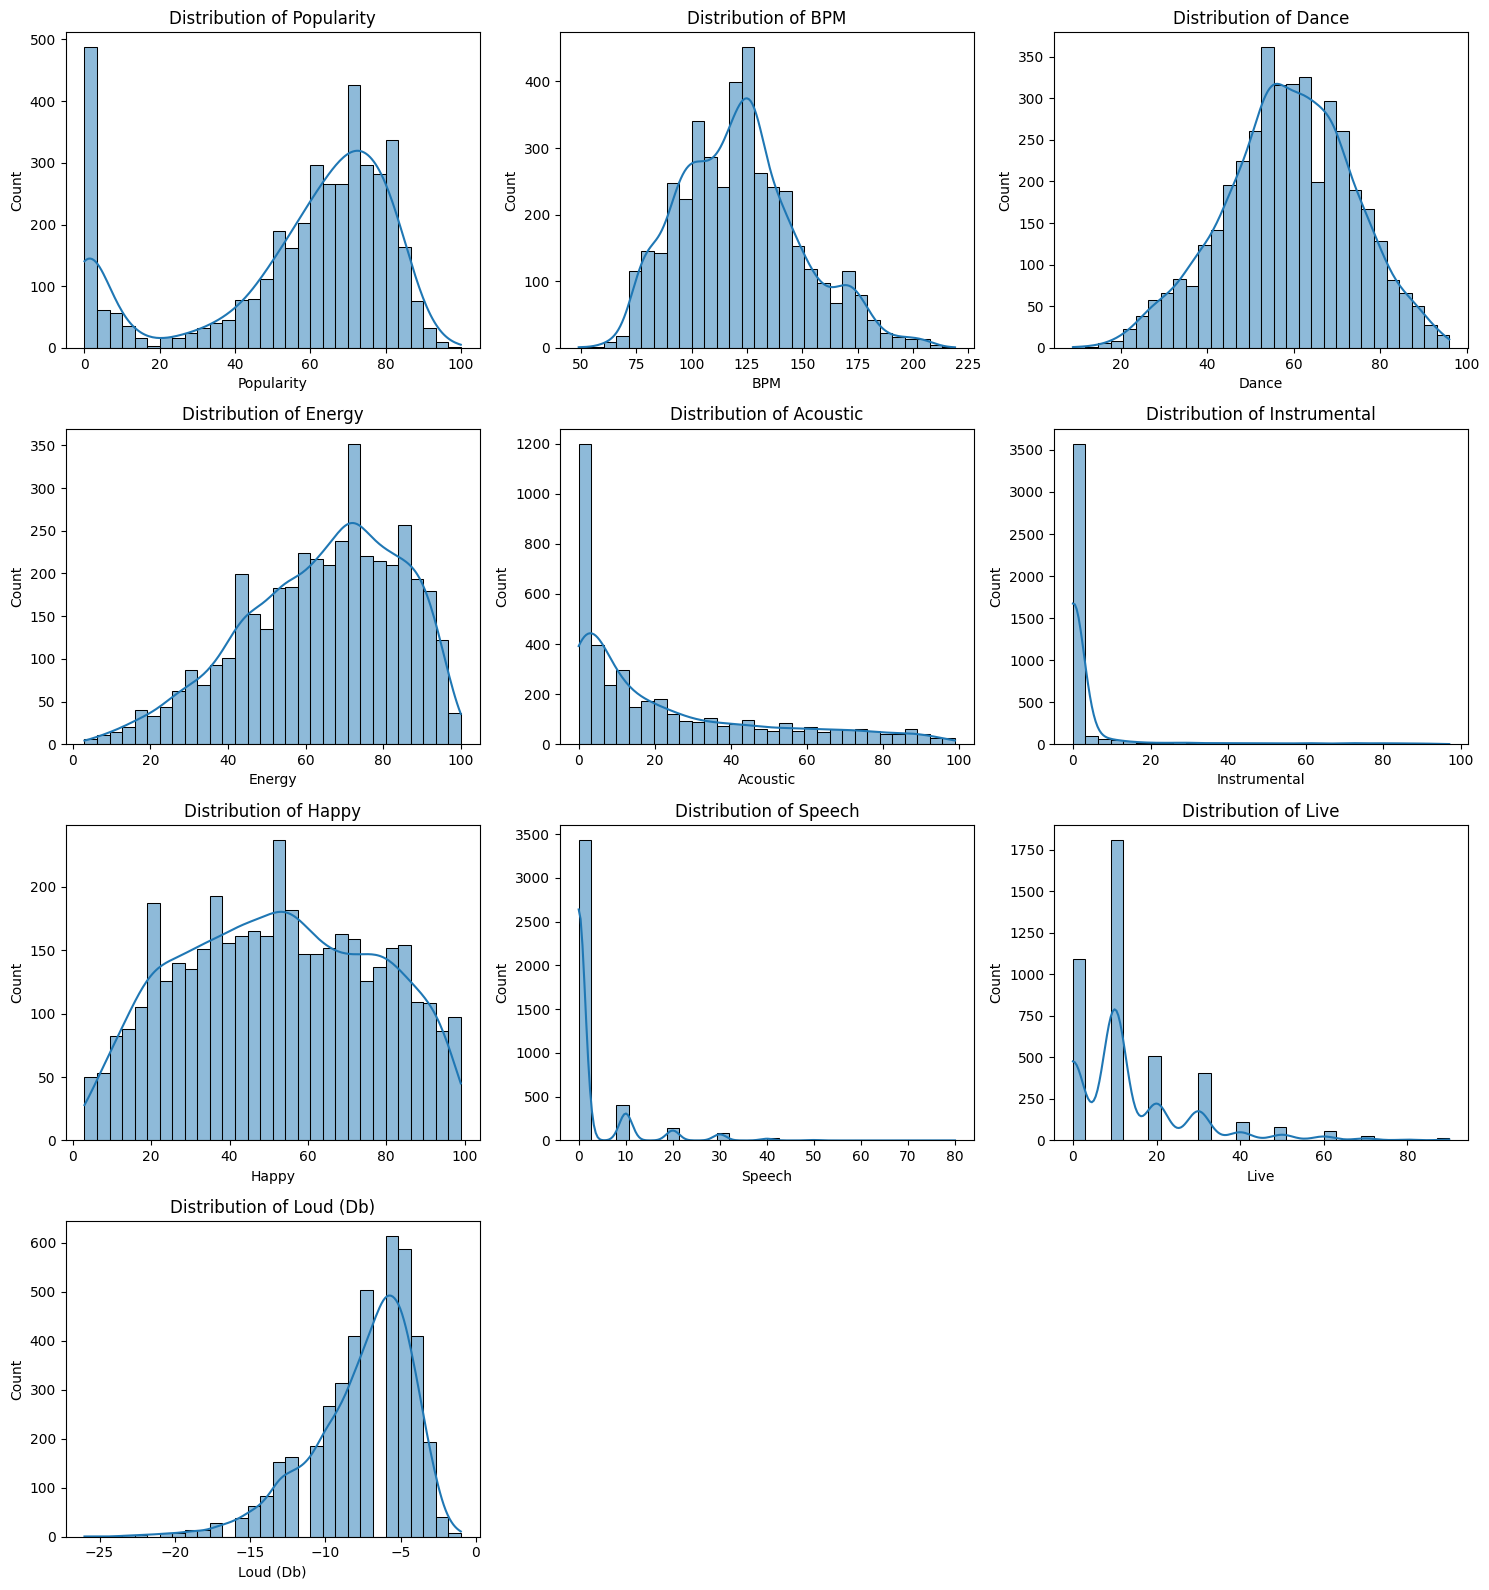

In [24]:

import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns only
numeric_cols = df.select_dtypes(include=['number']).columns

# Set up the plotting grid — adjust size as needed
n_cols = 3  # number of plots per row
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Based on the distribution shapes we are going to drop 'Speech' and 'Instrumental'

In [25]:
# Drop columns 'Instrumental' and 'Speech'
df = df.drop(columns=['Instrumental', 'Speech'])

In looking at the data some very popular songs how low popularity scores and this could heavily skew the model output. Removing songs with a popularity below 20 will give us a normal distribution of popularity scores. It will also eliminate some unpopular, unknown songs to save the model from making some unpopular recommendations.

### Drop songs with popularity less than 20

In [26]:
df = df[df['Popularity'] >= 20].reset_index(drop=True)

In [27]:
top_artists = df['Artist'].value_counts().head(20)

print(top_artists)

Artist
Taylor Swift         41
Drake                37
Morgan Wallen        37
The Weeknd           29
Bryson Tiller        25
Luke Combs           25
Billy Joel           24
Wallows              21
Bob Dylan            20
Zach Bryan           20
Coldplay             16
Frank Ocean          16
Arctic Monkeys       15
Travis Scott         14
Pink Floyd           14
Bruce Springsteen    14
Lana Del Rey         14
Leonard Cohen        14
ABBA                 14
SZA                  13
Name: count, dtype: int64


In [28]:
df.head()

,Song,Artist,Popularity,BPM,Time,Dance,Energy,Acoustic,Happy,Live,Loud (Db),Camelot,Artist_Clean,Song_Clean,Genre Tags,lyrics
0,BIRDS OF A FEATHER,Billie Eilish,100,105,03:30,75,51,20,44,10,-10,10B,Billie Eilish,BIRDS OF A FEATHER,"alt-pop, 2024, peter, pop, indie pop",(But I wanna stay)\n\nI want you to stay\n'Til...
1,Die With A Smile,"Lady Gaga,Bruno Mars",98,158,04:11,52,59,31,54,10,-8,11A,Lady Gaga,Die With A Smile,"Bruno Mars, pop, soft rock, pop rock, Lady Gaga","(Ooh, ooh)\n\nI, I just woke up from a dream\n..."
2,WILDFLOWER,Billie Eilish,96,148,04:21,47,25,61,13,10,-12,11A,Billie Eilish,WILDFLOWER,"edu e marco, peter, pop, dream pop, indie folk",Things fall apart\nAnd time breaks your heart\...
3,back to friends,sombr,95,93,03:19,44,72,0,24,0,-2,3B,sombr,back to friends,"alternative rock, indie rock, gay anthem, gay ...",Touch my body tender\n'Cause the feeling makes...
4,"Good Luck, Babe!",Chappell Roan,94,117,03:38,70,58,5,79,0,-6,10A,Chappell Roan,"Good Luck, Babe!","synthpop, pop rock, new wave, baroque pop, pop","It's fine, it's cool\nYou can say that we are ..."


We want to convert 'Time' into seconds

In [29]:
# Removing Redundant Columns
df = df.drop(columns=['Artist_Clean', 'Song_Clean'])

### Genre Splitting 

Each genre column has 5 genre tags. We must split these tags into seperate genre columns.

In [30]:
genre_split = df['Genre Tags'].str.split(',', expand=True)

genre_split = genre_split.apply(lambda col: col.str.strip())

def clean_genre(genre):
    if pd.isna(genre):
        return None
    genre = genre.strip().lower()              # trim and lowercase
    genre = genre.replace('&', 'and')          # normalize symbols
    genre = genre.replace('-', ' ')            # normalize hyphens
    genre = genre.replace('/', ' ')            # normalize slashes
    genre = genre.replace('  ', ' ')           # remove double spaces
    return genre

# Apply cleaning to each genre column
genre_split_cleaned = genre_split.applymap(clean_genre)

genre_split_cleaned.columns = ['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5']
df = pd.concat([df, genre_split_cleaned], axis=1)

C:\Users\Ryan\AppData\Local\Temp\ipykernel_30032\3241988939.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genre_split_cleaned = genre_split.applymap(clean_genre)


In [31]:
# Define genre columns
genre_cols = ['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5']

# Define replacements for normalization
replacements = {
    'rap': 'hip hop',
    'new wave': '80s',
    'classic rock': 'rock'
}

# Apply replacements across all genre columns
df[genre_cols] = df[genre_cols].applymap(lambda x: replacements.get(x, x))

C:\Users\Ryan\AppData\Local\Temp\ipykernel_30032\3040467931.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[genre_cols] = df[genre_cols].applymap(lambda x: replacements.get(x, x))


Define Primary and Secondary Genres for each Song

In [32]:
# Combine all genre columns into one Series
all_genres = genre_split_cleaned.stack().reset_index(drop=True)

# Count frequency of each genre
genre_counts = all_genres.value_counts()

# Filter for genres appearing more than 100 times
popular_genres = genre_counts[genre_counts > 100]

# Display popular genres
print(popular_genres)

rock                 1025
pop                   973
hip hop               496
indie                 476
alternative           460
classic rock          440
80s                   424
female vocalists      386
70s                   315
dance                 281
rap                   281
singer songwriter     278
rnb                   265
indie rock            250
electronic            247
soul                  241
indie pop             218
country               201
folk                  190
alternative rock      182
myspotigrambot        168
90s                   141
oldies                130
british               128
new wave              127
60s                   120
disco                 115
synthpop              113
love                  105
Name: count, dtype: int64


In [33]:
# Define major genres (core categories)
major_genres = {
    'rock', 'pop', 'hip hop', 'indie', 'alternative',
    'dance', 'rnb', 'electronic', 'soul', 'country', 'folk'
}

# Define secondary genres (includes eras and substyles)
secondary_genres = major_genres.union({
    '60s', '70s', '80s', '90s', 'disco', 'synthpop'
})

# List of genre columns in the DataFrame
genre_cols = ['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5']

# Function to assign primary and secondary genres to each song
def assign_primary_secondary(row):
    # Extract non-null genres from the row
    genres = [row[col] for col in genre_cols if pd.notna(row[col])]

    # Step 1: Check for compound genres (e.g., "rock 80s")
    for g in genres:
        if not isinstance(g, str):
            continue
        parts = g.strip().lower().split()
        if len(parts) == 2:
            part1, part2 = parts[0], parts[1]
            if ((part1 in major_genres and part2 in secondary_genres) or
                (part2 in major_genres and part1 in secondary_genres) or
                (part1 in major_genres and part2 in major_genres)):
                return pd.Series([part1, part2])  # Return compound genre parts

    # Step 2a: Assign primary genre (first major genre found)
    primary = next((g for g in genres if g in major_genres), None)

    # Step 2b: Assign secondary genre (first secondary ≠ primary)
    if primary:
        secondary = next((g for g in genres if g in secondary_genres and g != primary), None)
    else:
        secondary = None

    return pd.Series([primary, secondary])

# Apply genre assignment to each row in the DataFrame
df[['primary_genre', 'secondary_genre']] = df.apply(assign_primary_secondary, axis=1)

In [34]:
# Count how many rows are missing a primary genre
missing_primary_count = df['primary_genre'].isna().sum()
print(f"Missing primary genres: {missing_primary_count}")

Missing primary genres: 401


In [35]:
# Drop rows without a primary genre
df = df.dropna(subset=['primary_genre'])

# Reset index after dropping rows
df = df.reset_index(drop=True)

# Drop original genre tag columns (raw and split)
df = df.drop(columns=['Genre Tags', 'Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5'])

In [36]:
# Print frequency count for each primary genre
df['primary_genre'].value_counts()

primary_genre
pop            561
rock           545
indie          538
hip hop        325
alternative    275
country        194
soul           151
electronic     143
dance          114
folk           111
rnb             87
90s              2
disco            1
80s              1
Name: count, dtype: int64

In [37]:
# Print frequency count for each secondary genre
df['secondary_genre'].value_counts()

secondary_genre
rock           506
pop            405
80s            372
70s            241
rnb            142
60s            104
90s             89
alternative     89
dance           86
folk            62
disco           51
indie           48
electronic      45
synthpop        42
soul            36
hip hop         27
country          8
Name: count, dtype: int64

In [38]:
# Step 1: Combine primary and secondary genres into a single string (e.g., "pop rock")
df['genre_pair'] = df.apply(
    lambda row: f"{row['primary_genre']} {row['secondary_genre']}" 
    if pd.notna(row['primary_genre']) and pd.notna(row['secondary_genre']) 
    else (row['primary_genre'] if pd.notna(row['primary_genre']) else None),
    axis=1
)

# Step 2: Count genre pair frequencies
genre_pair_counts = df['genre_pair'].value_counts()
genre_pair_counts.columns = ['genre_pair', 'count']

# Display all genre pair counts
print(genre_pair_counts)

genre_pair
hip hop             232
indie pop           207
indie rock          204
pop 80s             172
alternative rock    165
                   ... 
folk 80s              1
rnb dance             1
rnb disco             1
disco pop             1
folk alternative      1
Name: count, Length: 136, dtype: int64


In [39]:
df['genre_pair_counts'] = df['genre_pair'].map(genre_pair_counts)

df['genre_pair'] = df.apply(
    lambda row: row['primary_genre'] if row['genre_pair_counts'] < 15 else row['genre_pair'],
    axis=1
)

df.drop(columns='genre_pair_counts', inplace=True)


genre_pair_counts = df['genre_pair'].value_counts()
genre_pair_counts.columns = ['genre_pair', 'count']

print(genre_pair_counts)

genre_pair
hip hop              270
indie pop            207
indie rock           204
pop 80s              172
alternative rock     165
rock 70s             151
rock 80s             146
country              130
rock                 119
pop                  117
electronic            89
rnb                   87
pop rock              74
folk                  65
dance                 65
country pop           64
indie                 64
alternative           59
rock 60s              55
alternative rnb       51
dance pop             49
pop dance             47
indie folk            46
pop 70s               46
folk rock             46
soul                  45
rock alternative      43
hip hop rnb           36
soul 70s              34
rock 90s              31
electronic dance      28
pop 90s               27
electronic pop        26
soul rnb              23
pop 60s               22
pop rnb               21
hip hop 90s           19
pop synthpop          19
soul 80s              18
indie alternat

In [40]:
df = df.drop(columns=['secondary_genre'])

### Renaming Some Variables

In [41]:

df = df.rename(columns={
    'Loud (Db)': 'Loud',
    'lyrics': 'Lyrics',
    'time_seconds': 'Time',
    'primary_genre': 'Genre',
    'genre_pair': 'Subgenre'
})

In [42]:
# We decided to drop "time" and "live" from our dataset as we felt they are not great predictors on if someone will like the song or not.
df = df.drop(columns=['Live', 'Time'])

In [43]:
df.head()

,Song,Artist,Popularity,BPM,Dance,Energy,Acoustic,Happy,Loud,Camelot,Lyrics,Genre,Subgenre
0,BIRDS OF A FEATHER,Billie Eilish,100,105,75,51,20,44,-10,10B,(But I wanna stay)\n\nI want you to stay\n'Til...,indie,indie pop
1,Die With A Smile,"Lady Gaga,Bruno Mars",98,158,52,59,31,54,-8,11A,"(Ooh, ooh)\n\nI, I just woke up from a dream\n...",pop,pop rock
2,WILDFLOWER,Billie Eilish,96,148,47,25,61,13,-12,11A,Things fall apart\nAnd time breaks your heart\...,indie,indie folk
3,back to friends,sombr,95,93,44,72,0,24,-2,3B,Touch my body tender\n'Cause the feeling makes...,alternative,alternative rock
4,"Good Luck, Babe!",Chappell Roan,94,117,70,58,5,79,-6,10A,"It's fine, it's cool\nYou can say that we are ...",pop,pop rock


In [44]:
df.to_csv('final_dataset.csv', index=False)

Our First round of Data Cleaning reduced our dataset from 4489 to 3449 (1040 rows). The dropped rows were mostly duplicates or unpopular songs. 

# EDA and Further Cleaning

In [45]:
df = pd.read_csv('final_dataset.csv')


In [46]:
df.head()

,Song,Artist,Popularity,BPM,Dance,Energy,Acoustic,Happy,Loud,Camelot,Lyrics,Genre,Subgenre
0,BIRDS OF A FEATHER,Billie Eilish,100,105,75,51,20,44,-10,10B,(But I wanna stay)\n\nI want you to stay\n'Til...,indie,indie pop
1,Die With A Smile,"Lady Gaga,Bruno Mars",98,158,52,59,31,54,-8,11A,"(Ooh, ooh)\n\nI, I just woke up from a dream\n...",pop,pop rock
2,WILDFLOWER,Billie Eilish,96,148,47,25,61,13,-12,11A,Things fall apart\nAnd time breaks your heart\...,indie,indie folk
3,back to friends,sombr,95,93,44,72,0,24,-2,3B,Touch my body tender\n'Cause the feeling makes...,alternative,alternative rock
4,"Good Luck, Babe!",Chappell Roan,94,117,70,58,5,79,-6,10A,"It's fine, it's cool\nYou can say that we are ...",pop,pop rock


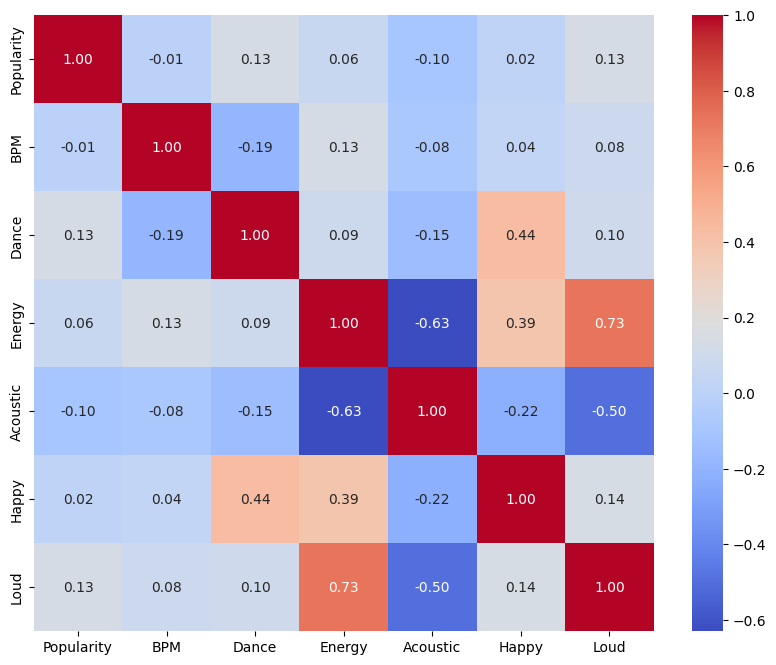

In [47]:
df_numeric = df.drop(columns=['Song', 'Artist', 'Camelot', 'Lyrics', 'Genre', 'Subgenre'])

corr_matrix = df_numeric.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [48]:
#Use the count methods to get the number of observations for each genre within the dataset.
genre_counts = df['Genre'].value_counts()

# Display counts and percentages
#Create a header for reabability
print("Genre Distribution:")
print("==================")

#Create a for loop that calculates the percentge of each genre in the dataset.
#Prints the genre, genre count, and the calculated percentage. 
for genre, count in genre_counts.items():
    percentage = (count/len(df)) * 100
    print(f"{genre}: {count} songs ({percentage:.1f}%)")

Genre Distribution:
pop: 561 songs (18.4%)
rock: 545 songs (17.9%)
indie: 538 songs (17.7%)
hip hop: 325 songs (10.7%)
alternative: 275 songs (9.0%)
country: 194 songs (6.4%)
soul: 151 songs (5.0%)
electronic: 143 songs (4.7%)
dance: 114 songs (3.7%)
folk: 111 songs (3.6%)
rnb: 87 songs (2.9%)
90s: 2 songs (0.1%)
disco: 1 songs (0.0%)
80s: 1 songs (0.0%)


As we can see, the most frequent genres are pop, rock, and indie at about 18%. The least common genre is rnb at 2.5%.

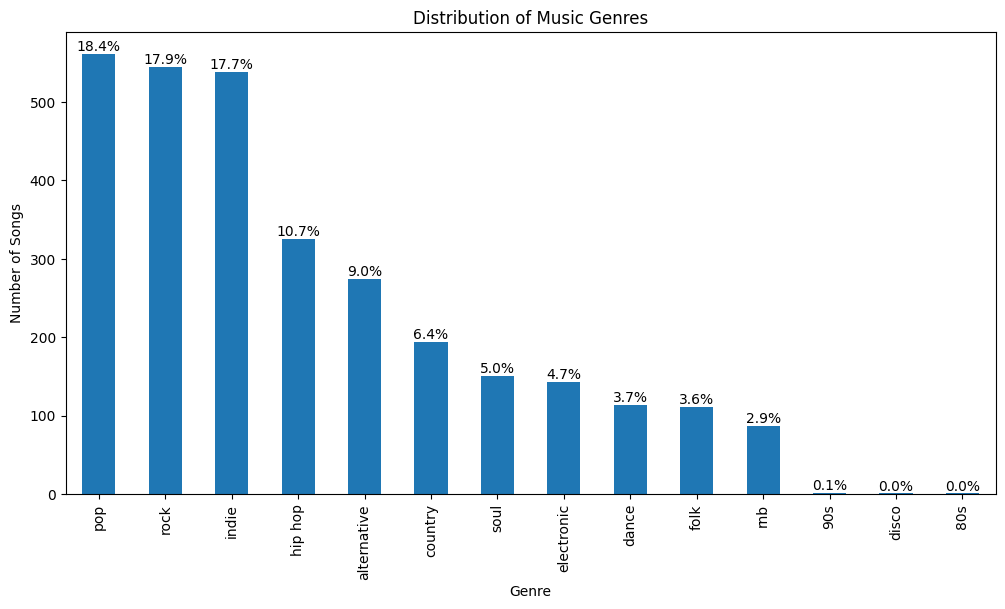

In [49]:
#Create a bar plot to display the genre count data (including percentages)

#Resize the figure to a wider and slightly taller chart to fit all the data
plt.figure(figsize=(12, 6))
#Initiate a bar plot (pandas)
ax = genre_counts.plot(kind='bar')

# Add percentage labels on top of each bar
total = len(df)
for i, v in enumerate(genre_counts):
    percentage = (v/total) * 100        #calculating the percentage with the genre count / total observations
    ax.text(i, v, f'{percentage:.1f}%', 
            ha='center', va='bottom')   #placing the text in the center-bottom of each bar
    
plt.title('Distribution of Music Genres')    #Chart Label
plt.xlabel('Genre')                          #X-axis label
plt.ylabel('Number of Songs')                #Y-axis label
plt.show()

We will repeat the same process for subgenres.

In [50]:
#Get subgenre counts
subgenre_counts = df['Subgenre'].value_counts()


# Display counts and percentages
#Create a header for reabability
print("Subgenre Distribution:")
print("==================")

#Create a for loop that calculates the percentge of each genre in the dataset.
#Prints the genre, genre count, and the calculated percentage. 
for subgenre, count in subgenre_counts.items():
    percentage = (count/len(df)) * 100
    print(f"{subgenre}: {count} songs ({percentage:.1f}%)")

Subgenre Distribution:
hip hop: 270 songs (8.9%)
indie pop: 207 songs (6.8%)
indie rock: 204 songs (6.7%)
pop 80s: 172 songs (5.6%)
alternative rock: 165 songs (5.4%)
rock 70s: 151 songs (5.0%)
rock 80s: 146 songs (4.8%)
country: 130 songs (4.3%)
rock: 119 songs (3.9%)
pop: 117 songs (3.8%)
electronic: 89 songs (2.9%)
rnb: 87 songs (2.9%)
pop rock: 74 songs (2.4%)
folk: 65 songs (2.1%)
dance: 65 songs (2.1%)
country pop: 64 songs (2.1%)
indie: 64 songs (2.1%)
alternative: 59 songs (1.9%)
rock 60s: 55 songs (1.8%)
alternative rnb: 51 songs (1.7%)
dance pop: 49 songs (1.6%)
pop dance: 47 songs (1.5%)
indie folk: 46 songs (1.5%)
pop 70s: 46 songs (1.5%)
folk rock: 46 songs (1.5%)
soul: 45 songs (1.5%)
rock alternative: 43 songs (1.4%)
hip hop rnb: 36 songs (1.2%)
soul 70s: 34 songs (1.1%)
rock 90s: 31 songs (1.0%)
electronic dance: 28 songs (0.9%)
pop 90s: 27 songs (0.9%)
electronic pop: 26 songs (0.9%)
soul rnb: 23 songs (0.8%)
pop 60s: 22 songs (0.7%)
pop rnb: 21 songs (0.7%)
hip hop 90

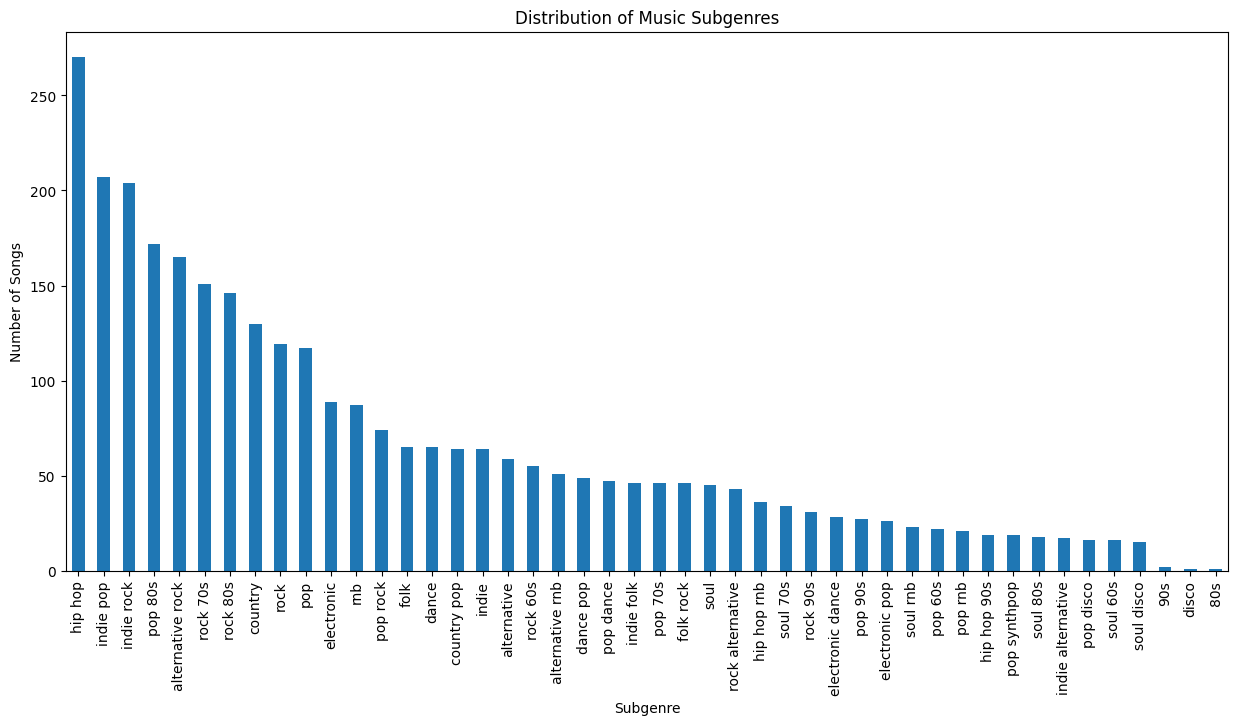

In [51]:
#Bar chart showing the distribution of subgenres.

plt.figure(figsize=(15, 7))  #widening the chart due to larger number of subgenres than genres
ax = subgenre_counts.plot(kind='bar')   #Initialize bar chart

#Chart aesthetics
plt.title('Distribution of Music Subgenres')
plt.xlabel('Subgenre')
plt.ylabel('Number of Songs')
plt.show()

As we can see, the distribution of subgenres is much more complex than genres due to the larger number of subgenres. There are about 7u subgenres that are much more common than the others (hip hop, indie rock, indie pop, pop 80s, alternative rock, rock 70s, rock 80s).

To better understand certain genres have a higher change of containing certain subgenres the next step taken was to create a horizaontal bar chart showing the distribution of each subgenre within each genre. This will give us a better understanding of relationships between genre and subgenre.

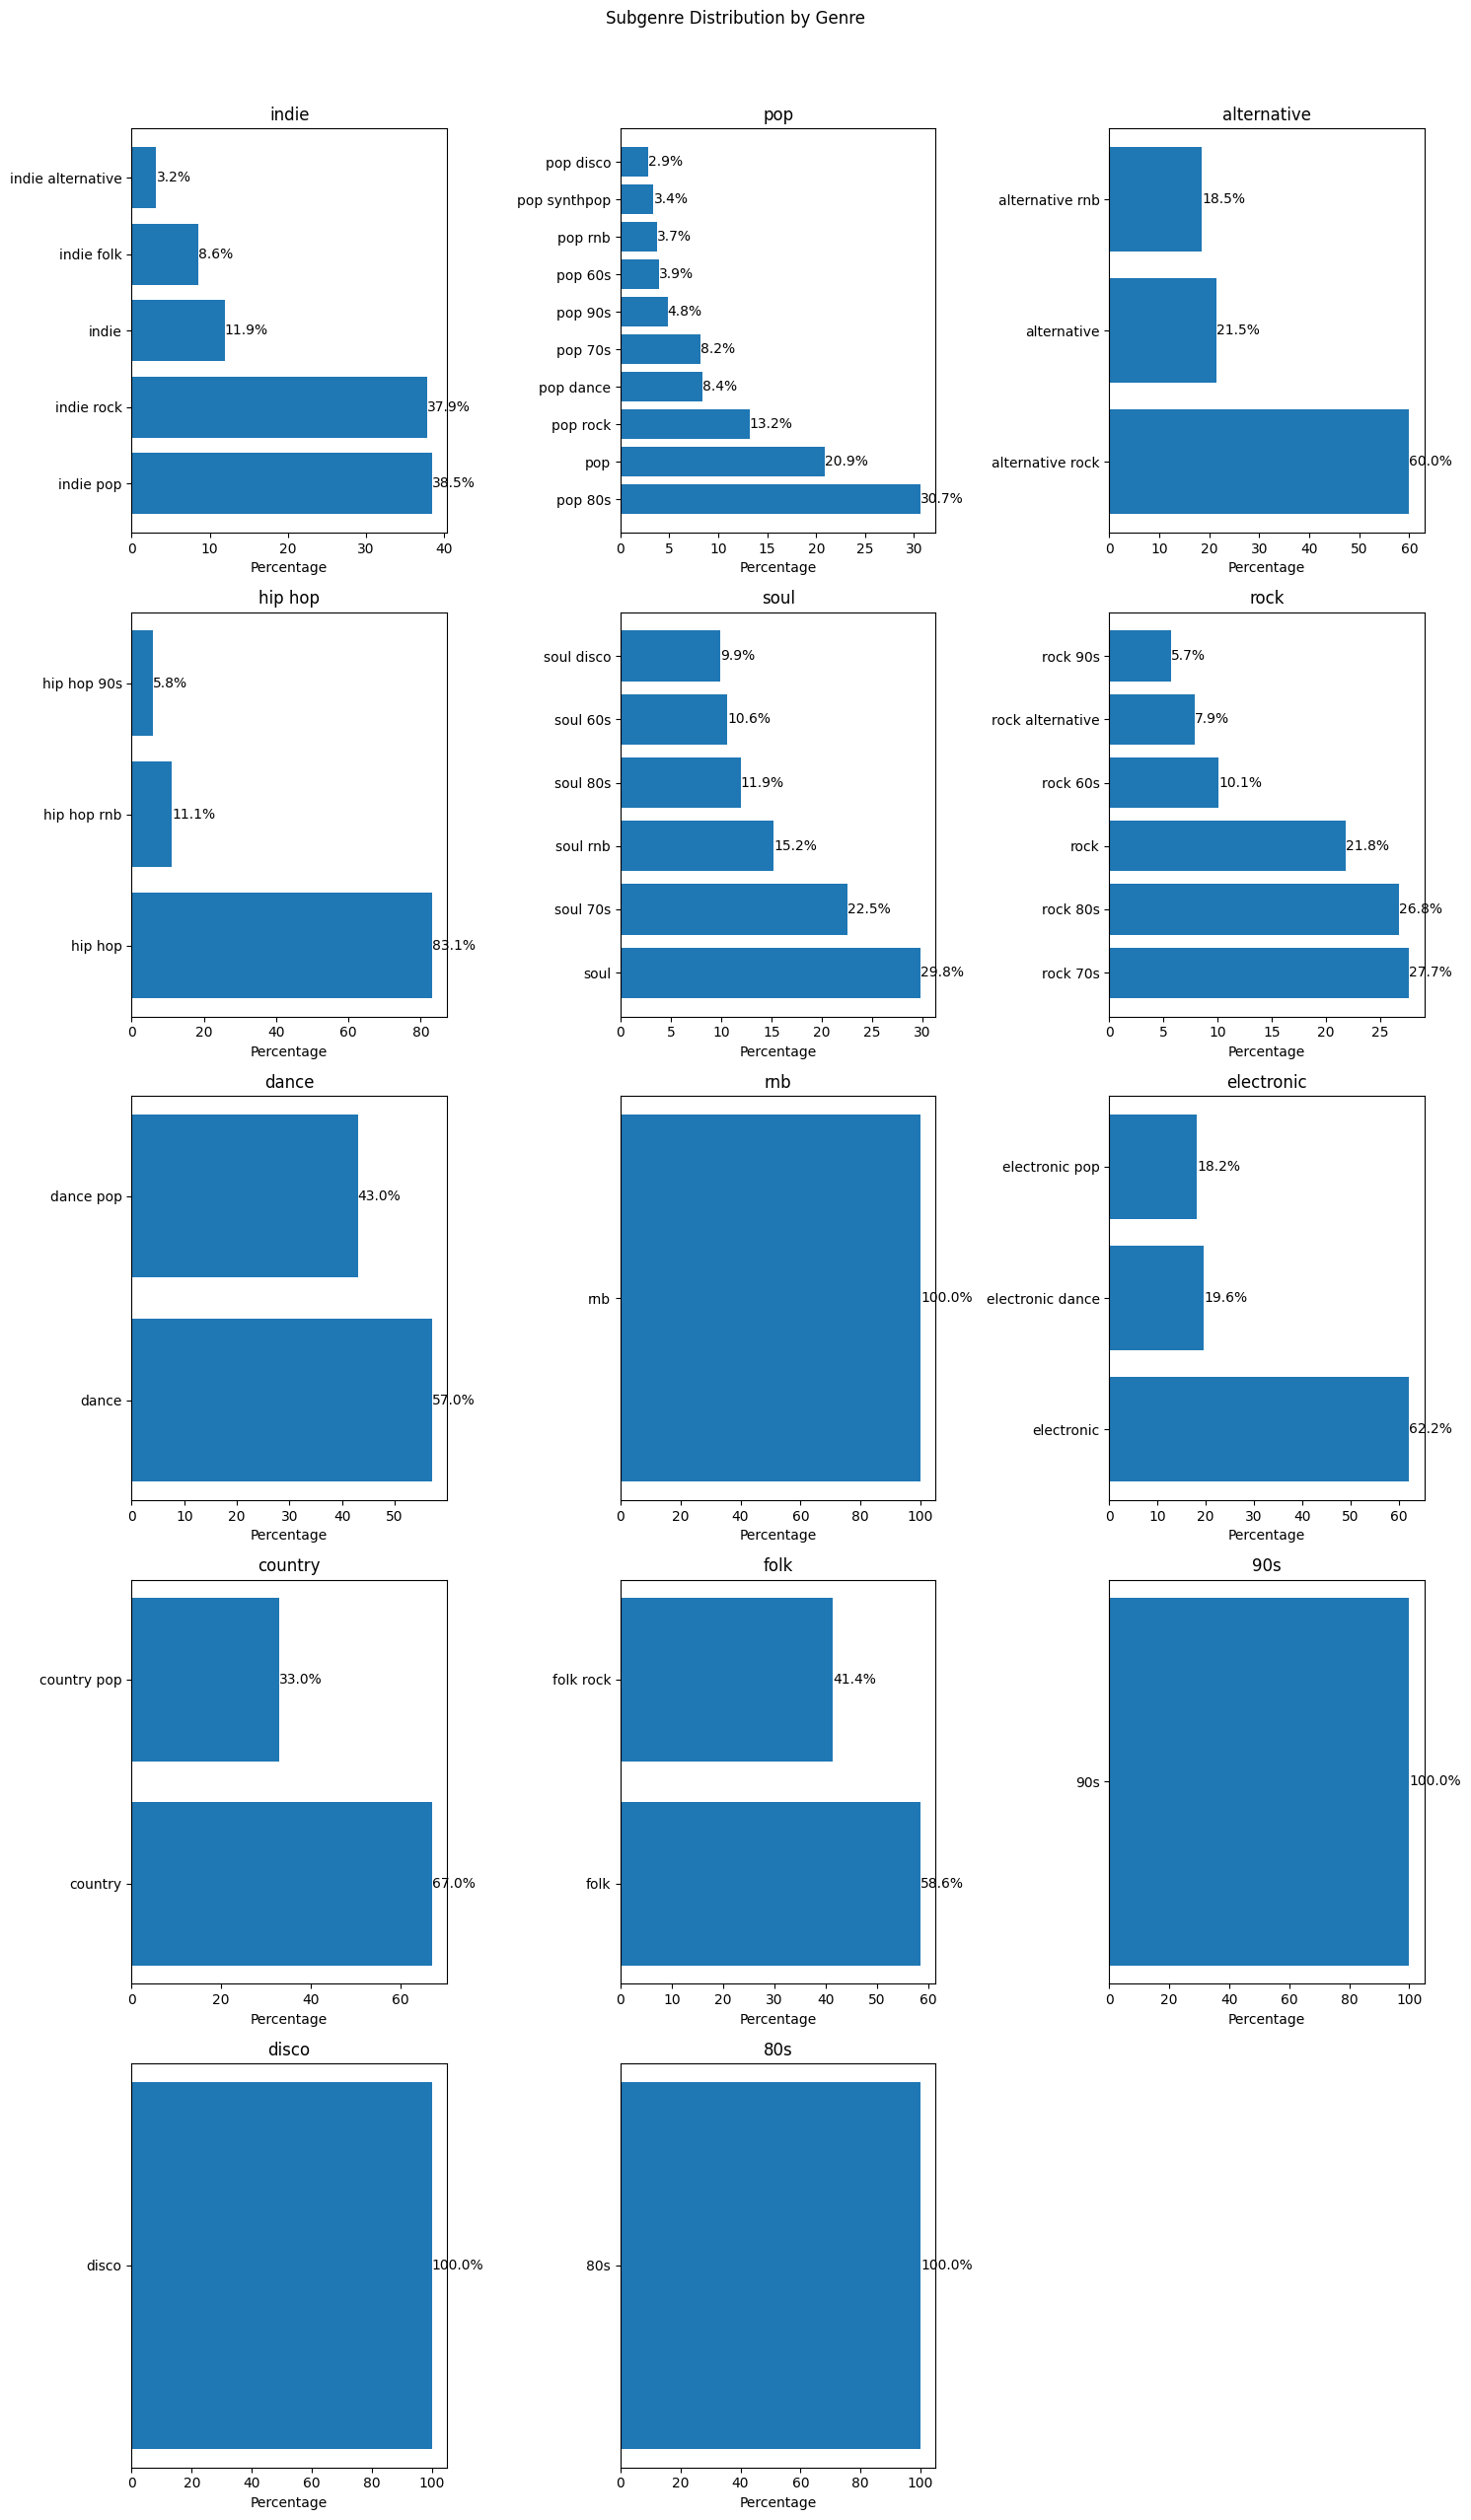

In [52]:
#Create a subplot for each genre showing the distribution of subgenres within that genre

# Calculate number of rows and columns for subplot grid
n_genres = len(df['Genre'].unique())   #Count of unique genres
n_cols = 3  # setting the column number to 3 in the grid
n_rows = (n_genres + n_cols - 1) // n_cols  # calculate the rows needed

# Create subplot grid
fig = plt.figure(figsize=(15, 5*n_rows)) #setting subplot size - can play with this
fig.suptitle('Subgenre Distribution by Genre',  y=1.02) #Main figure title and moving it slightly up to not overlap other labels

# Create a subplot for each genre with a for loop
for i, genre in enumerate(df['Genre'].unique()):
    ax = plt.subplot(n_rows, n_cols, i+1)                     # creating a subplot in position i+1 on the plot (defined above).
    
    genre_data = df[df['Genre'] == genre]         # Get data for current genre in the for loop.
    subgenre_counts = genre_data['Subgenre'].value_counts()   # Use the count method for the current genre's subgenres.
    total = len(genre_data)                                   # Total number of songs that belong to the current genre.
    
    # Create percentage data
    percentages = (subgenre_counts/total) * 100
    
    # Initiate horizontal bar chart
    bars = ax.barh(subgenre_counts.index, percentages)     # assigning 'percentages' to the x-axis and 'subgenres' to the y-axis (horizontal bar)
    
    # Add percentage labels in the center of the far right of each bar.
    for bar in bars:
        width = bar.get_width()       # bar length (horizontal)
        ax.text(width,                # position where the bar ends
                bar.get_y() + bar.get_height()/2,   # y -coordinates (middle of bar) 
                f'{width:.1f}%',                    # the label - making it a percentage with 1 decimal
                va='center')                        # centering the text vertically for neater presentation                       
    
    ax.set_title(f'{genre}')
    ax.set_xlabel('Percentage')

plt.tight_layout()
plt.show()

For the most part, each genre has one or two main subgenres that account for a lot of the distribution. This is useful information as more analysis and decisions will have to me made to not over bias the model if certain subgenres can be considered a proxy for a genre.

In [53]:
# Printing summary statistics for each audio feature in the dataset.
df.describe()

,Popularity,BPM,Dance,Energy,Acoustic,Happy,Loud
count,3048.000000,3048.000000,3048.00000,3048.000000,3048.000000,3048.000000,3048.000000
mean,66.902231,121.053806,58.93143,64.302165,23.749672,53.191929,-7.728018
std,13.887481,27.406715,14.94634,20.037516,26.509883,24.549787,3.443364
min,20.000000,49.000000,11.00000,4.000000,0.000000,3.000000,-26.000000
25%,59.000000,101.000000,49.00000,51.000000,2.000000,33.000000,-10.000000
50%,69.000000,120.000000,59.00000,67.000000,13.000000,54.000000,-7.000000
75%,77.000000,136.250000,69.00000,80.000000,38.000000,73.000000,-5.000000
max,100.000000,219.000000,96.00000,100.000000,99.000000,99.000000,-1.000000


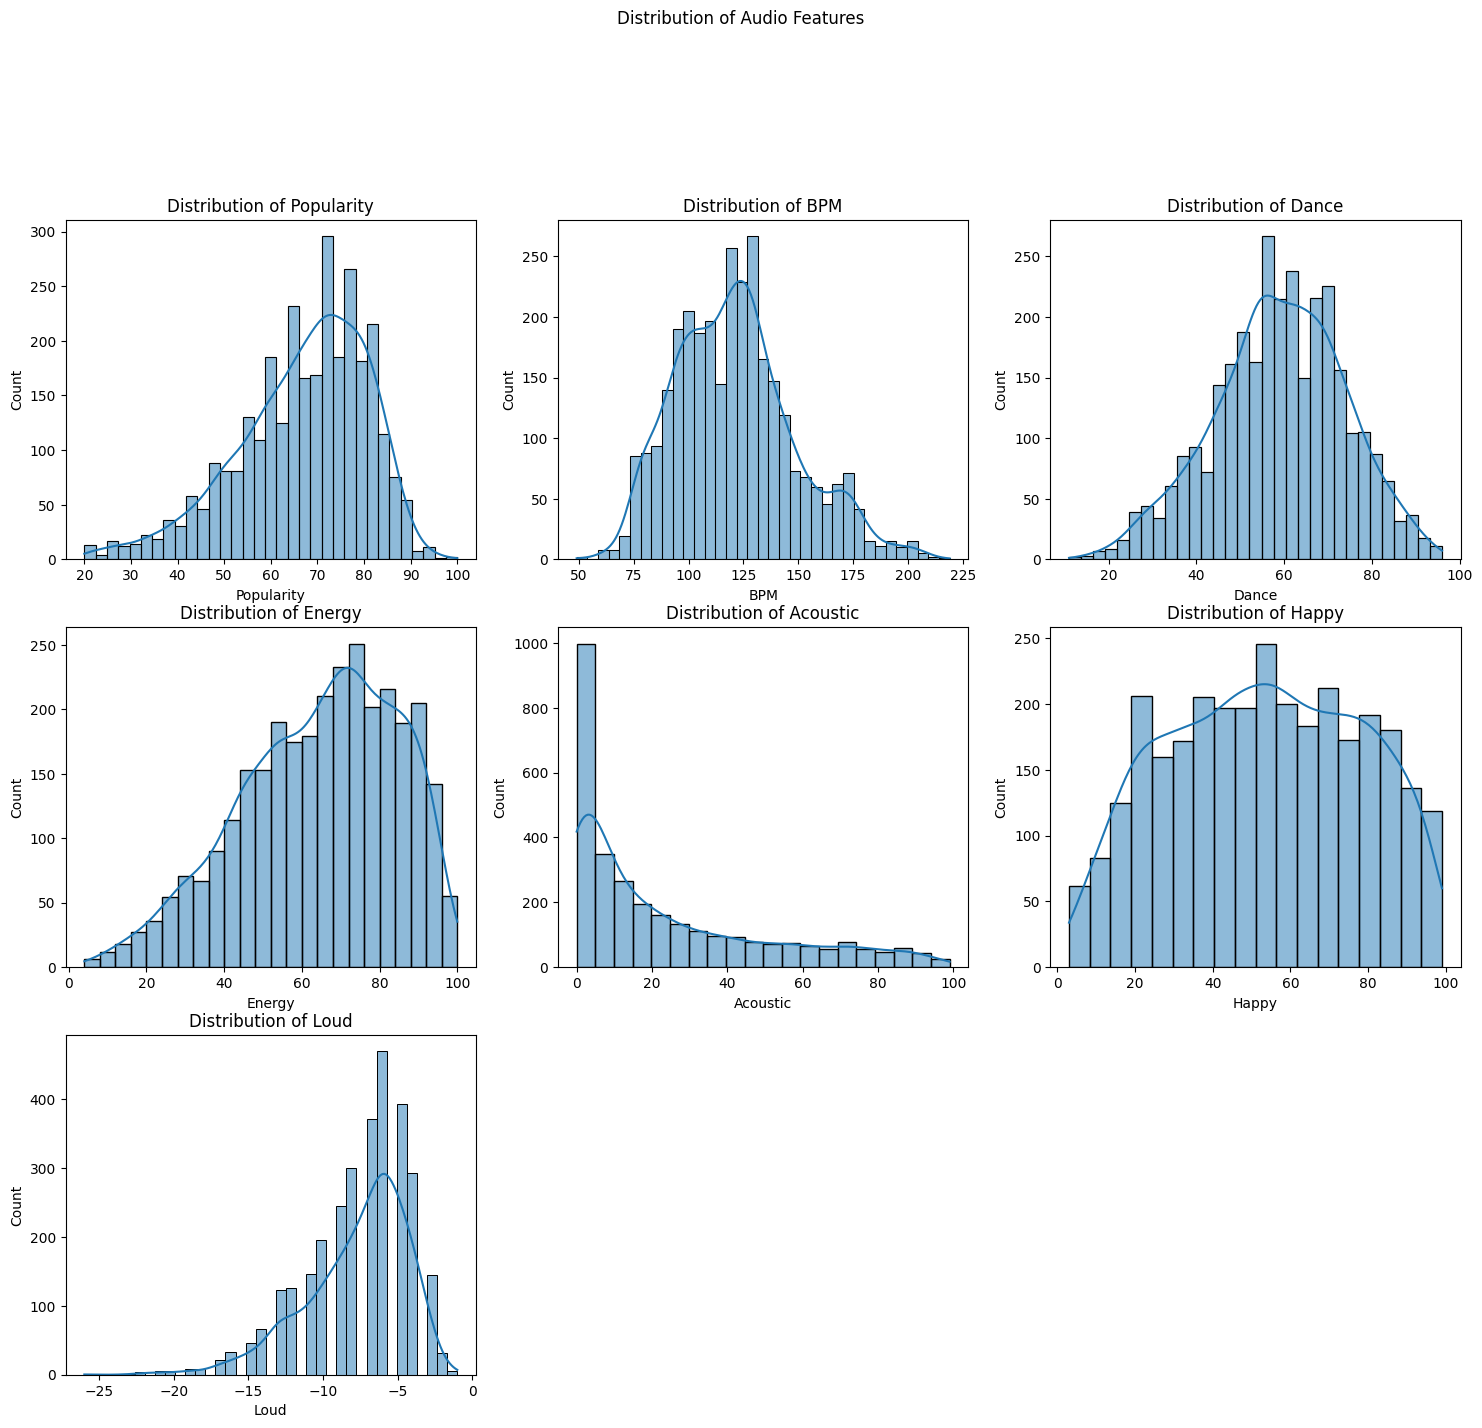

In [54]:
# Create histogram distribition plots for each of the audio features described above. 

# Select numeric audio features
numeric_columns = ['Popularity', 'BPM', 'Dance', 'Energy', 'Acoustic', 'Happy', 'Loud']

# Calculate number of rows needed for 3 columns
n_rows = (len(numeric_columns) + 2) // 3  

# Create subplot grid with 3 columns
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(18, 5*n_rows))   # can play with the dimensions
fig.suptitle('Distribution of Audio Features',  y=1.02)                   # main title and moving it slightly up to not overlap other labels

# Flatten axes array to 1D (vs 2D) for easier indexing 
axes = axes.flatten() 

# Create distribution plots for each audio feature using a for loop
for i, column in enumerate(numeric_columns):
    # Histogram with KDE
    sns.histplot(data=df,                 # define where the data is coming from
                 x=column,                      # define x
                 kde=True,                      # kde creates a smooth curve over the histogram
                 ax=axes[i])                    # sets the subplot to populate in the for loop

    # labels
    axes[i].set_title(f'Distribution of {column}')     
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

C:\Users\Ryan\AppData\Local\Temp\ipykernel_30032\3504759773.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
C:\Users\Ryan\AppData\Local\Temp\ipykernel_30032\3504759773.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
C:\Users\Ryan\AppData\Local\Temp\ipykernel_30032\3504759773.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
C:\Users\Ryan\AppData\Local\Temp\ipykernel_30032\3504759773.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a 

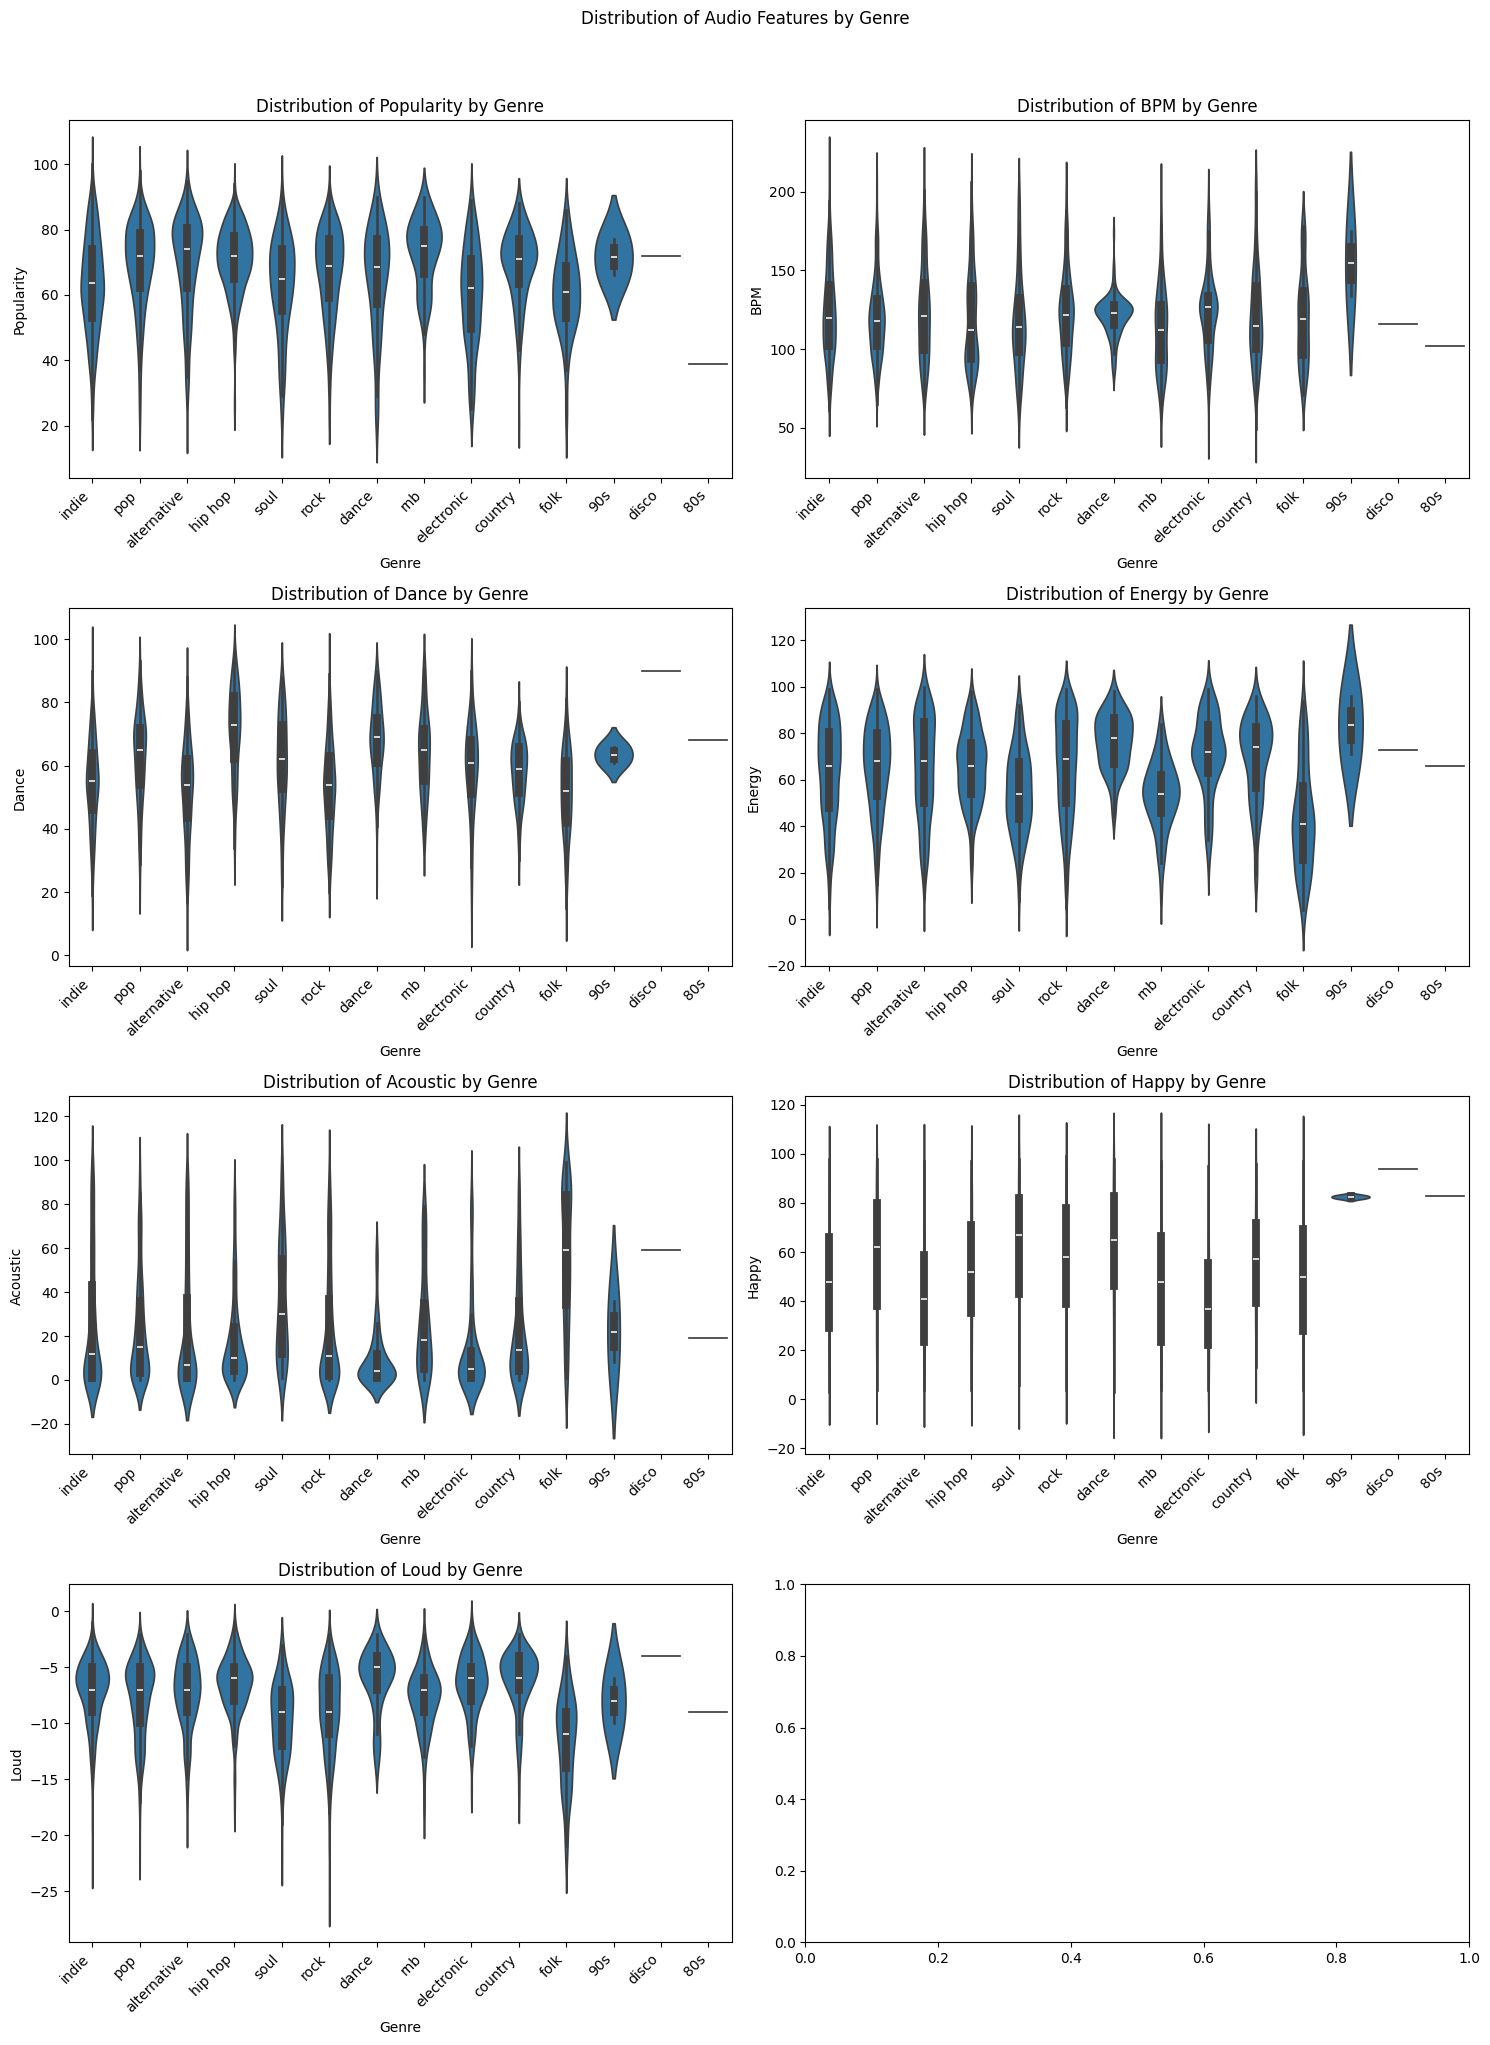

In [55]:
# Create violin plots. This will show the feature distibutions across all the genres. This will allow us to see if specific genres are more
# or less extreme for a specific feature in relation to the dataset. This can help identify areas the model may weight heavily in differentiating genres.


# Select the numeric audio features.
numeric_columns = ['Popularity', 'BPM', 'Dance', 'Energy', 'Acoustic', 'Happy', 'Loud']

# Create subplot grid (same process as the previous plots)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
fig.suptitle('Distribution of Audio Features by Genre', y=1.02)

# Flatten axes array to 1D (vs 2D) for easier indexing
axes = axes.flatten()

# Create distribution plots for each feature using a for loop
for i, column in enumerate(numeric_columns):
    # Create violin plot with boxplot inside 
    sns.violinplot(data=df,                     # Define the data source     
                   x='Genre',                         # Set the x-axis (genre)
                   y=column,                          # Set the y-axis (numeric audio feature measurements)
                   ax=axes[i])
    
    # Rotate x-axis labels for better readability. Making the labels tilted 45 degrees.
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    # Titles and labels
    axes[i].set_title(f'Distribution of {column} by Genre')
    axes[i].set_xlabel('Genre')
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()

In [56]:
# Create a dataframe/table showing the mean value per genre for each audio feature.
# Use the groupby function to group features by genre and then calculate the mean for each.
summary_df = pd.DataFrame({
    'Popularity': df.groupby('Genre')['Popularity'].mean(),
    'BPM': df.groupby('Genre')['BPM'].mean(),
    'Dance': df.groupby('Genre')['Dance'].mean(),
    'Energy': df.groupby('Genre')['Energy'].mean(),
    'Acoustic': df.groupby('Genre')['Acoustic'].mean(),
    'Happy': df.groupby('Genre')['Happy'].mean(),
    'Loud': df.groupby('Genre')['Loud'].mean()
}).round(2)

# Display the table
print("\nMean Values by Genre:")
print(summary_df)


Mean Values by Genre:
             Popularity     BPM  Dance  Energy  Acoustic  Happy   Loud
Genre                                                                 
80s               39.00  102.00  68.00   66.00     19.00  83.00  -9.00
90s               71.50  154.50  63.50   83.50     22.00  82.50  -8.00
alternative       69.99  123.04  52.46   64.99     22.53  43.16  -7.36
country           69.44  120.22  58.08   69.13     22.25  55.79  -6.18
dance             65.38  121.00  68.17   76.42      9.21  62.13  -6.12
disco             72.00  116.00  90.00   73.00     59.00  94.00  -4.00
electronic        59.83  123.71  59.47   70.89     13.34  40.76  -6.48
folk              60.72  119.17  51.57   43.49     56.93  48.79 -11.47
hip hop           70.83  117.89  70.98   65.24     17.41  51.87  -6.58
indie             63.21  123.00  54.72   63.54     25.59  48.46  -7.21
pop               69.22  119.98  62.93   65.25     23.27  58.83  -7.84
rnb               72.99  112.89  63.72   53.56     25.

### Lyric Cleaning

In [57]:
df = pd.read_csv('final_dataset.csv')

In [58]:
# Load spaCy model and stopwords
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
stop_words = set(stopwords.words("english"))

def clean_lyrics(text):
    if pd.isnull(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)

    # Remove [annotations like chorus/verse]
    text = re.sub(r"\[.*?\]", "", text)

    # Remove all punctuation (including apostrophes) - modification from week 4 to 5.
    text = re.sub(r"[^a-z0-9\s]", "", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize with spaCy
    doc = nlp(text)

    # Lemmatize and remove stopwords
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.lemma_ not in stop_words]

    return " ".join(tokens)

In [59]:
df['Clean_Lyrics'] = df['Lyrics'].apply(clean_lyrics)

In [60]:
df = df.drop(columns='Lyrics')

In [61]:
df.head()

,Song,Artist,Popularity,BPM,Dance,Energy,Acoustic,Happy,Loud,Camelot,Genre,Subgenre,Clean_Lyrics
0,BIRDS OF A FEATHER,Billie Eilish,100,105,75,51,20,44,-10,10B,indie,indie pop,wanna stay want stay til grave til rot away de...
1,Die With A Smile,"Lady Gaga,Bruno Mars",98,158,52,59,31,54,-8,11A,pop,pop rock,ooh ooh wake dream say goodbye know mean since...
2,WILDFLOWER,Billie Eilish,96,148,47,25,61,13,-12,11A,indie,indie folk,thing fall apart time break heart know girl sh...
3,back to friends,sombr,95,93,44,72,0,24,-2,3B,alternative,alternative rock,touch body tender cause feeling make weak kick...
4,"Good Luck, Babe!",Chappell Roan,94,117,70,58,5,79,-6,10A,pop,pop rock,fine cool say nothing know truth guess fool ar...


### Feature Engineering and Normalization

In [62]:
# Add interaction term 'Power': Power = Loud * Energy
df['Power'] = df['Loud'] * df['Energy']

# Drop original features
df.drop(columns=['Loud', 'Energy'], inplace=True)

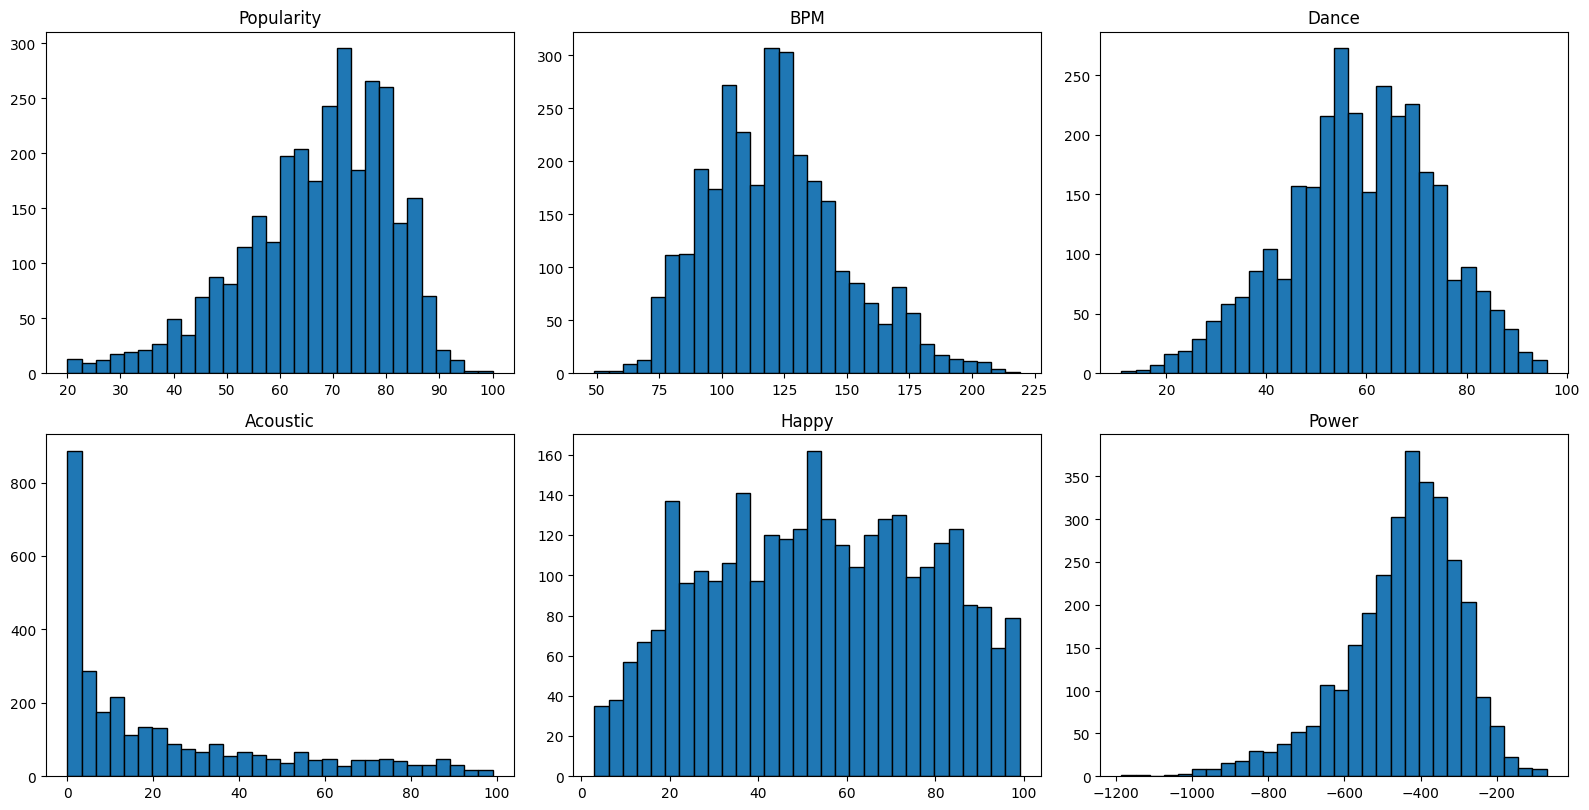

In [63]:
# List of numeric columns
numeric_cols = ['Popularity', 'BPM', 'Dance', 'Acoustic', 'Happy', 'Power']

# Set up subplots
plt.figure(figsize=(16, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[col], bins=30, edgecolor='k')
    plt.title(col)

plt.tight_layout()
plt.show()

Camelot in practice is a circular scale. We could one hot encode 0-23, but 23 and 0 are just as close on the Camelot scale as 0 and 1. Instead we will code Camelot to have sin and cos coordinates (mapping on the unit circle) to better model songs in latent space.

In [64]:
#Circular encoding for Camelot

def camelot_to_position(code):
    number = int(code[:-1])   # extract number (1-12)
    mode = code[-1]           # extract mode (A or B)
    mode_offset = 0 if mode == 'A' else 12        # Start at 0 if mode is A, if not start at 13
    return (number - 1) + mode_offset 

def add_sin_cos(df):
    df['camelot_pos'] = df['Camelot'].map(camelot_to_position) #map camelot positions to 0-23
    df['camelot_sin'] = np.sin(2 * np.pi * df['camelot_pos'] / 24)        #compute sine transformation 
    df['camelot_cos'] = np.cos(2 * np.pi * df['camelot_pos'] / 24)        #compute cosine transformation
    df.drop(['Camelot', 'camelot_pos'], axis=1, inplace=True)             #Drop camelot and intermediate position column.
    return df

# Apply Camelot transformation
df = add_sin_cos(df)

In [65]:
# Apply square root to Acoustic
df['sqrt_Acoustic'] = np.sqrt(df['Acoustic'])

# Apply square root to BPM
df['sqrt_BPM'] = np.sqrt(df['BPM'])

# Drop original columns to avoid redundancy
df.drop(columns=['Acoustic', 'BPM'], inplace=True)

In [66]:
df.head()

,Song,Artist,Popularity,Dance,Happy,Genre,Subgenre,Clean_Lyrics,Power,camelot_sin,camelot_cos,sqrt_Acoustic,sqrt_BPM
0,BIRDS OF A FEATHER,Billie Eilish,100,75,44,indie,indie pop,wanna stay want stay til grave til rot away de...,-510,-0.707107,0.707107,4.472136,10.246951
1,Die With A Smile,"Lady Gaga,Bruno Mars",98,52,54,pop,pop rock,ooh ooh wake dream say goodbye know mean since...,-472,0.500000,-0.866025,5.567764,12.569805
2,WILDFLOWER,Billie Eilish,96,47,13,indie,indie folk,thing fall apart time break heart know girl sh...,-300,0.500000,-0.866025,7.810250,12.165525
3,back to friends,sombr,95,44,24,alternative,alternative rock,touch body tender cause feeling make weak kick...,-144,-0.500000,-0.866025,0.000000,9.643651
4,"Good Luck, Babe!",Chappell Roan,94,70,79,pop,pop rock,fine cool say nothing know truth guess fool ar...,-348,0.707107,-0.707107,2.236068,10.816654


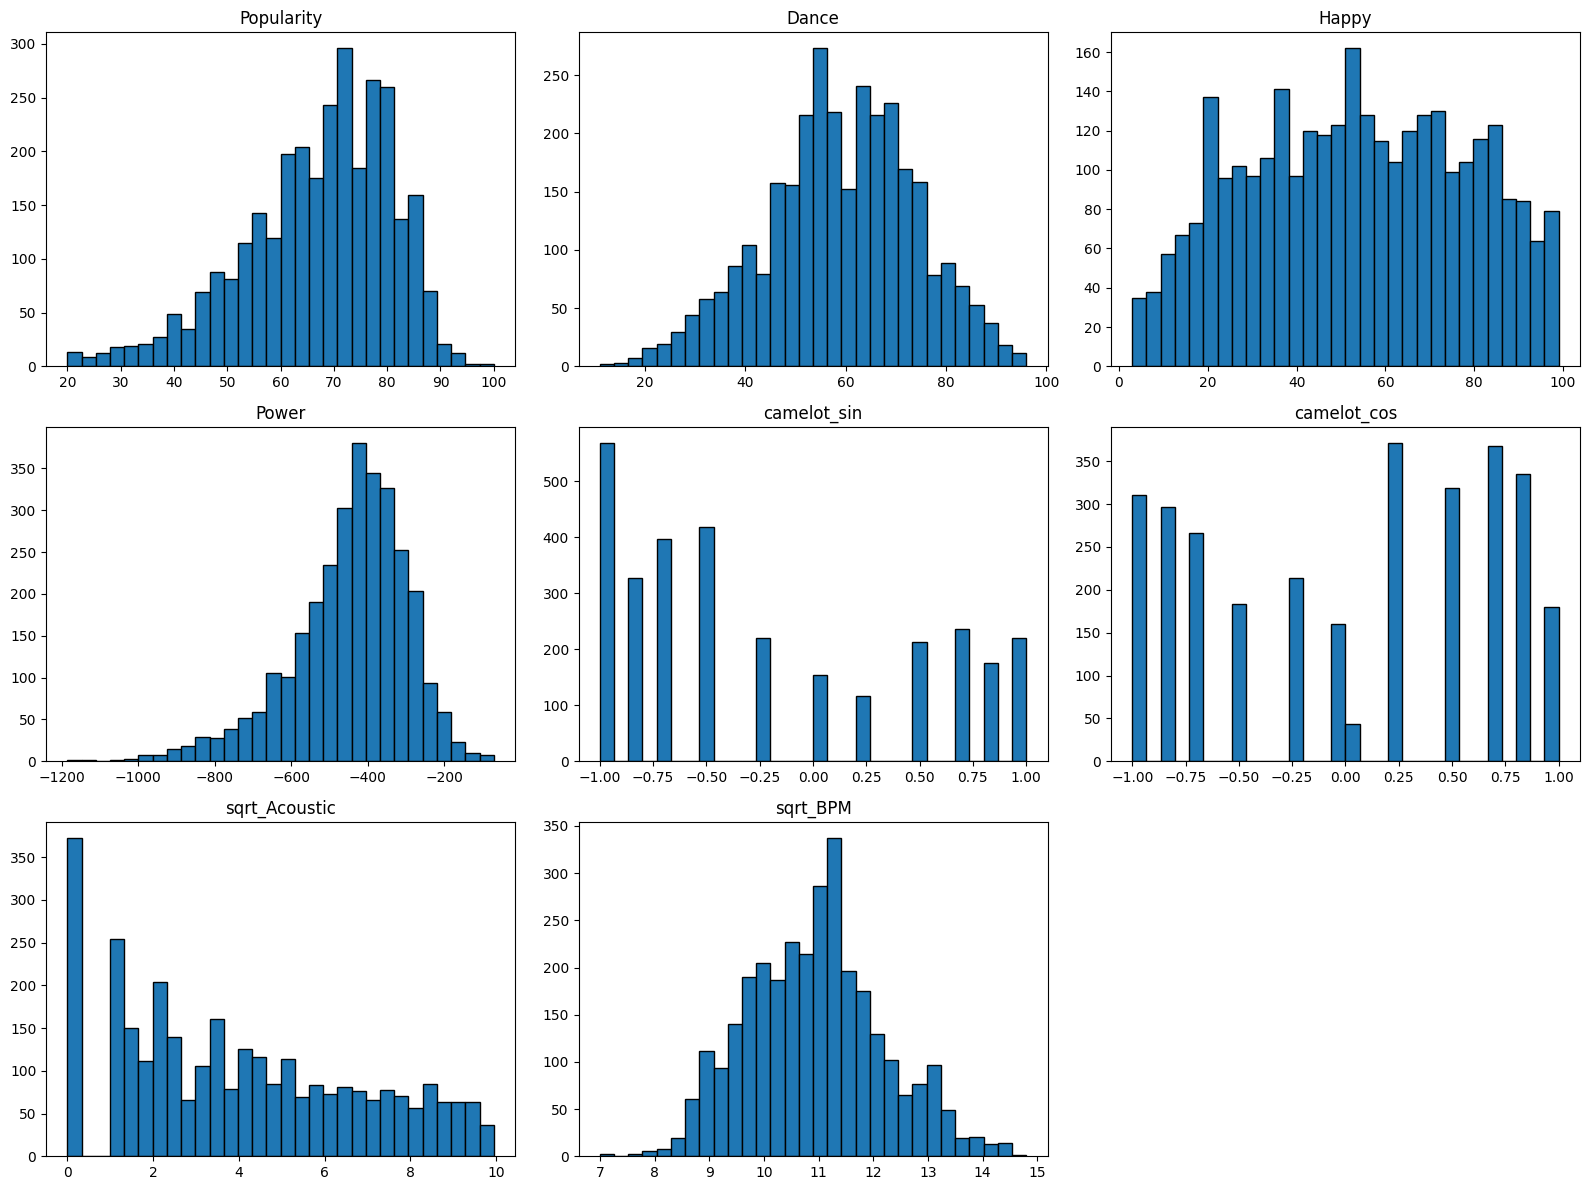

In [67]:
# List of numeric columns
numeric_cols = ['Popularity', 'Dance', 'Happy', 'Power', 'camelot_sin', 'camelot_cos', 'sqrt_Acoustic', 'sqrt_BPM']

# Set up subplots
plt.figure(figsize=(16, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[col], bins=30, edgecolor='k')
    plt.title(col)

plt.tight_layout()
plt.show()

### Scale the Data

In [68]:

# Define the numeric columns to scale
numeric_cols = ['Popularity', 'Dance', 'Happy', 'Power', 'sqrt_Acoustic', 'sqrt_BPM']
# Note: camelot_sin and camelot_cos are excluded due to unit circle representation

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the selected numeric columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Calculate scaled means
scaled_means = df[numeric_cols].mean()

# Create a summary DataFrame
scaler_summary = pd.DataFrame({
    'feature': numeric_cols,
    'original_min': scaler.data_min_,
    'original_max': scaler.data_max_,
    'scaler': scaler.scale_,          # 1 / (max - min)
    'scaled_mean': scaled_means.values
})

# Set feature as index and display
scaler_summary.set_index('feature', inplace=True)
display(scaler_summary)


,original_min,original_max,scaler,scaled_mean
feature,,,,
Popularity,20.0,100.000000,0.012500,0.586278
Dance,11.0,96.000000,0.011765,0.563899
Happy,3.0,99.000000,0.010417,0.522833
Power,-1185.0,-70.000000,0.000897,0.662148
sqrt_Acoustic,0.0,9.949874,0.100504,0.397701
sqrt_BPM,7.0,14.798649,0.128227,0.504318


In [69]:
df.describe()

,Popularity,Dance,Happy,Power,camelot_sin,camelot_cos,sqrt_Acoustic,sqrt_BPM
count,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000
mean,0.586278,0.563899,0.522833,0.662148,-0.234152,0.027662,0.397701,0.504318
std,0.173594,0.175839,0.255727,0.135687,0.691389,0.683153,0.285931,0.158293
min,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000
25%,0.487500,0.447059,0.312500,0.594619,-0.866025,-0.707107,0.142134,0.391077
50%,0.612500,0.564706,0.531250,0.681614,-0.500000,0.258819,0.362372,0.507069
75%,0.712500,0.682353,0.729167,0.751345,0.500000,0.707107,0.619547,0.599155
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### One-Hot Encode Genres

In [70]:
df.head()

,Song,Artist,Popularity,Dance,Happy,Genre,Subgenre,Clean_Lyrics,Power,camelot_sin,camelot_cos,sqrt_Acoustic,sqrt_BPM
0,BIRDS OF A FEATHER,Billie Eilish,1.0000,0.752941,0.427083,indie,indie pop,wanna stay want stay til grave til rot away de...,0.605381,-0.707107,0.707107,0.449467,0.416348
1,Die With A Smile,"Lady Gaga,Bruno Mars",0.9750,0.482353,0.531250,pop,pop rock,ooh ooh wake dream say goodbye know mean since...,0.639462,0.500000,-0.866025,0.559581,0.714201
2,WILDFLOWER,Billie Eilish,0.9500,0.423529,0.104167,indie,indie folk,thing fall apart time break heart know girl sh...,0.793722,0.500000,-0.866025,0.784960,0.662362
3,back to friends,sombr,0.9375,0.388235,0.218750,alternative,alternative rock,touch body tender cause feeling make weak kick...,0.933632,-0.500000,-0.866025,0.000000,0.338988
4,"Good Luck, Babe!",Chappell Roan,0.9250,0.694118,0.791667,pop,pop rock,fine cool say nothing know truth guess fool ar...,0.750673,0.707107,-0.707107,0.224733,0.489399


In [71]:
# Create a list of variables we want to encode
one_hot_cols = ['Genre', 'Subgenre']

In [72]:
# One-hot encoder (for Genre and Subgenre)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder to the dataset
encoder.fit(df[one_hot_cols])

,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [73]:
# Helper function to transform and reattach
def encode_and_concat(df, encoder, categorical_cols):
    encoded = encoder.transform(df[categorical_cols])
    encoded_df = pd.DataFrame(
        encoded,
        columns=encoder.get_feature_names_out(categorical_cols),
        index=df.index
    )
    return pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)

# Apply encoding to the full DataFrame
df = encode_and_concat(df, encoder, one_hot_cols)

In [74]:
list(df.columns)

['Song',
 'Artist',
 'Popularity',
 'Dance',
 'Happy',
 'Clean_Lyrics',
 'Power',
 'camelot_sin',
 'camelot_cos',
 'sqrt_Acoustic',
 'sqrt_BPM',
 'Genre_80s',
 'Genre_90s',
 'Genre_alternative',
 'Genre_country',
 'Genre_dance',
 'Genre_disco',
 'Genre_electronic',
 'Genre_folk',
 'Genre_hip hop',
 'Genre_indie',
 'Genre_pop',
 'Genre_rnb',
 'Genre_rock',
 'Genre_soul',
 'Subgenre_80s',
 'Subgenre_90s',
 'Subgenre_alternative',
 'Subgenre_alternative rnb',
 'Subgenre_alternative rock',
 'Subgenre_country',
 'Subgenre_country pop',
 'Subgenre_dance',
 'Subgenre_dance pop',
 'Subgenre_disco',
 'Subgenre_electronic',
 'Subgenre_electronic dance',
 'Subgenre_electronic pop',
 'Subgenre_folk',
 'Subgenre_folk rock',
 'Subgenre_hip hop',
 'Subgenre_hip hop 90s',
 'Subgenre_hip hop rnb',
 'Subgenre_indie',
 'Subgenre_indie alternative',
 'Subgenre_indie folk',
 'Subgenre_indie pop',
 'Subgenre_indie rock',
 'Subgenre_pop',
 'Subgenre_pop 60s',
 'Subgenre_pop 70s',
 'Subgenre_pop 80s',
 'Subge

In [75]:
df.to_csv('df_model_ready')

PLESE NOTE: The CSV file after tokenization is too large to export comfortably. To run and save the model you must run the tokenization (section below) before fitting KNN!

### Tokenize the Lyrics

In [76]:
df = pd.read_csv('df_model_ready')

In [77]:
def simple_tokenize(text):
    return text.split()

df['Tokens'] = df['Clean_Lyrics'].apply(simple_tokenize)


In [78]:
import gensim.downloader as api

model = api.load("glove-twitter-200")  # 200-dimensional vectors


In [79]:
import numpy as np

def get_embedding_twitter(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [80]:
#Creates a column called 'Twitter_Embeddings" in all three of the dataframes/datasets by applying the get_embedding_twitter() function to the tokens list

df['Twitter_Embeddings'] = df['Tokens'].apply(lambda tokens: get_embedding_twitter(tokens, model))

In [81]:
#Allows us to work with the vector numerically
def str_to_embedding(s):
    # Remove [ and ] characters
    s = s.strip('[]')
    # Split by spaces and convert each to float
    return np.array([float(x) for x in s.split()])


In [82]:
df.head()

,Unnamed: 0,Song,Artist,Popularity,Dance,Happy,Clean_Lyrics,Power,camelot_sin,camelot_cos,...,Subgenre_rock 90s,Subgenre_rock alternative,Subgenre_soul,Subgenre_soul 60s,Subgenre_soul 70s,Subgenre_soul 80s,Subgenre_soul disco,Subgenre_soul rnb,Tokens,Twitter_Embeddings
0,0,BIRDS OF A FEATHER,Billie Eilish,1.0000,0.752941,0.427083,wanna stay want stay til grave til rot away de...,0.605381,-0.707107,0.707107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[wanna, stay, want, stay, til, grave, til, rot...","[-0.047858343, 0.07461265, -0.14072998, 0.0277..."
1,1,Die With A Smile,"Lady Gaga,Bruno Mars",0.9750,0.482353,0.531250,ooh ooh wake dream say goodbye know mean since...,0.639462,0.500000,-0.866025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[ooh, ooh, wake, dream, say, goodbye, know, me...","[-0.0070068683, 0.1782168, 0.05810058, -0.0168..."
2,2,WILDFLOWER,Billie Eilish,0.9500,0.423529,0.104167,thing fall apart time break heart know girl sh...,0.793722,0.500000,-0.866025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[thing, fall, apart, time, break, heart, know,...","[0.009144678, 0.108357064, -0.018592123, 0.047..."
3,3,back to friends,sombr,0.9375,0.388235,0.218750,touch body tender cause feeling make weak kick...,0.933632,-0.500000,-0.866025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[touch, body, tender, cause, feeling, make, we...","[-0.014792592, 0.09527639, 0.044679046, 0.0330..."
4,4,"Good Luck, Babe!",Chappell Roan,0.9250,0.694118,0.791667,fine cool say nothing know truth guess fool ar...,0.750673,0.707107,-0.707107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[fine, cool, say, nothing, know, truth, guess,...","[-0.01072527, 0.054249633, 0.04387761, 0.09387..."


In [83]:
df.columns

Index(['Unnamed: 0', 'Song', 'Artist', 'Popularity', 'Dance', 'Happy',
       'Clean_Lyrics', 'Power', 'camelot_sin', 'camelot_cos', 'sqrt_Acoustic',
       'sqrt_BPM', 'Genre_80s', 'Genre_90s', 'Genre_alternative',
       'Genre_country', 'Genre_dance', 'Genre_disco', 'Genre_electronic',
       'Genre_folk', 'Genre_hip hop', 'Genre_indie', 'Genre_pop', 'Genre_rnb',
       'Genre_rock', 'Genre_soul', 'Subgenre_80s', 'Subgenre_90s',
       'Subgenre_alternative', 'Subgenre_alternative rnb',
       'Subgenre_alternative rock', 'Subgenre_country', 'Subgenre_country pop',
       'Subgenre_dance', 'Subgenre_dance pop', 'Subgenre_disco',
       'Subgenre_electronic', 'Subgenre_electronic dance',
       'Subgenre_electronic pop', 'Subgenre_folk', 'Subgenre_folk rock',
       'Subgenre_hip hop', 'Subgenre_hip hop 90s', 'Subgenre_hip hop rnb',
       'Subgenre_indie', 'Subgenre_indie alternative', 'Subgenre_indie folk',
       'Subgenre_indie pop', 'Subgenre_indie rock', 'Subgenre_pop',
       

In [84]:
print(type(df['Twitter_Embeddings'].iloc[0]))

<class 'numpy.ndarray'>


In [85]:
#Converts the "Embeddings" column into a 2D numpy array (matrix) where each row represents a song
X = np.stack(df['Twitter_Embeddings'].values)

## Fit The Model

It is time to fit our KNN Model. We are weighing each section of our data specifically. 

Metadata (Popularity, Dance, Happy, Power, camelot_sin, camelot_cos, sqrt_Acoutsic, sqrt_BPM) = 45%
Lyrics = 45%
Genre Tags = 10%

This mix gave us our best results.


In [86]:
#Omit subgenre, and embeddings (will add them later)

columns_to_exclude = [col for col in df.columns 
                      if col.startswith('Subgenre_') or 
                      col in ['Song', 'Artist', 'Clean_Lyrics', 'Tokens', 
                              'Twitter_Embeddings']]

In [87]:
# Get numeric metadata features - numerical data with only the columns we want (no embeddings)
X_meta = df.drop(columns=columns_to_exclude).select_dtypes(include=[np.number])

# Extract Twitter embeddings
X_embed = np.stack(df['Twitter_Embeddings'].values)

# Extract genre features (one-hot encoded)
X_genre = df.filter(like='Genre_')

# Apply weighting so that each block contributes 50% to the distance
m = X_meta.shape[1]   # number of metadata features
g = X_genre.shape[1]
e = X_embed.shape[1]  # number of embedding dimensions

# Weighting: ensure total sums to 1.0
meta_weight = np.sqrt(0.45 / m)
genre_weight = np.sqrt(0.1 / g)
embed_weight = np.sqrt(0.45 / e)

# Weighted feature arrays
X_full = np.hstack([
    X_meta * meta_weight,
    X_genre * genre_weight,
    X_embed * embed_weight
])

In [88]:
# Fit the KNN model using cosine distance 
KNN_Weighted = NearestNeighbors(n_neighbors=6, metric='cosine')
KNN_Weighted.fit(X_full)


,n_neighbors,6
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [89]:
# Test the Model
test_song_idx = 110
distances, indices = KNN_Weighted.kneighbors([X_full[test_song_idx]])

print(f"\nRecommendations for song: {df['Song'].iloc[test_song_idx]} by {df['Artist'].iloc[test_song_idx]}")

# Skip the first match (which will be the song itself)
for rank, (idx, dist) in enumerate(zip(indices[0][1:], distances[0][1:]), start=1):
    song = df['Song'].iloc[idx]
    artist = df['Artist'].iloc[idx]
    print(f"{rank}. {song} by {artist} (distance: {dist:.4f})")


Recommendations for song: ARE WE STILL FRIENDS? by Tyler, The Creator
1. Ain't No Mountain High Enough by Marvin Gaye,Tammi Terrell (distance: 0.0001)
2. If I Ain't Got You by Alicia Keys (distance: 0.0001)
3. Always by Daniel Caesar (distance: 0.0001)
4. Rocket Man (I Think It's Going To Be A Long, Long Time) by Elton John (distance: 0.0001)
5. Easy On Me by Adele (distance: 0.0001)


The chunk below is one way to use our model. That gets recommendations for the first 100 songs in the dataset. This can be adjusted to get recommendations for the first X songs or a random assortment of songs.

In [90]:

# Get top 2 neighbors for each song (so we can skip the self-match)
full_distances, full_indices = KNN_Weighted.kneighbors(X_full, n_neighbors=2)

full_recommendations = []

# Generate recommendations for the first 100 songs
for i in range(100):
    test_song_title = df.iloc[i]['Song']
    test_artist = df.iloc[i]['Artist']
    
    rec_idx = full_indices[i][1]  # [1] skips the self-match at [0]
    rec_song_title = df.iloc[rec_idx]['Song']
    rec_artist = df.iloc[rec_idx]['Artist']
    
    full_recommendations.append({
        'Test Song Title': test_song_title,
        'Test Artist': test_artist,
        'Recommended Song Title': rec_song_title,
        'Recommended Artist': rec_artist
    })

# Save to CSV
full_rec_df = pd.DataFrame(full_recommendations)
full_rec_df.to_csv('top_100_knn_weighted_w_genre_recommendations.csv', index=False)

print("Saved top 100 KNN_Weighted recommendations to 'knn_weighted_recommendations.csv'")

Saved top 100 KNN_Weighted recommendations to 'knn_weighted_recommendations.csv'


## Pickel the Model for Export and Deployment

Another way to deploy the model is to pickel it and deploy it on a Python interpretor like Spyder. Run our recommend.py script. 

In [91]:
import os
import pickle

# Save feature matrix
np.save(os.path.join(working_dir, 'data_array.npy'), X_full)

# Save DataFrame
df.to_csv(os.path.join(working_dir, 'final_df.csv'), index=False)

# Save model
with open(os.path.join(working_dir, 'knn_weighted_model.pkl'), 'wb') as f:
    pickle.dump(KNN_Weighted, f)

print("✅ All files saved to:", working_dir)

✅ All files saved to: C:\Users\Ryan\OneDrive\Documents\Final Project\Final_Script\Data
